In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Classroom/DSF/DSF Final Proj/DSF Project Fall 2021/data
# %cd /content/drive/MyDrive/DSF Project Fall 2021/data

/content/drive/.shortcut-targets-by-id/1uITAlwG_KLn52Rc6b51jPmC6XmnWK3r-/DSF Project Fall 2021/data


In [ ]:
ls

2016-17/                           final_predicted_scores_df_nov_30.pkl
2017-18/                           final_team_after_transfer.pkl
2018-19/                           master_team_list.csv
2019-20/                           merged_gw_2122.csv
2020-21/                           merged_gw_2122.gsheet
2021-22/                           merged_season_2021-22.csv
ashley_nov29_1.pkl                 merged_season_2021-22.gsheet
ashley_nov29.pkl                   spi_global_rankings.csv
cleaned_merged_seasons.csv         spi_global_rankings_intl.csv
cleaned_merged_seasons.csv.gsheet  spi_matches.csv
final_decisions_df.pkl             spi_matches_latest.csv


In [ ]:
pip install pulp

     |████████████████████████████████| 41.2 MB 1.3 MB/s 


In [ ]:
pip install colorama

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import permutation_test_score as perm_test
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median', add_indicator=True)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDClassifier
import requests
import pulp
from IPython.display import display, Markdown, Latex
from colorama import Fore, Style

In [ ]:
main_data = pd.read_csv("cleaned_merged_seasons.csv")
data = main_data.copy()
players =data['name'].unique()
merged_gw_21_22 = pd.read_csv("merged_season_2021-22.csv")
print(type(data))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>


In [ ]:
merged_gw_21_22.groupby(['GW']).count()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
GW,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554
2,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566,566
3,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577,577
4,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599,599
5,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606,606
6,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611,611
7,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613
8,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617,617
9,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618,618


In [ ]:
data

,Unnamed: 0,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,10,0,0,0.0,0.0,2016-08-15T19:00:00Z,0,4,Chelsea,0,0,0,0,1,0,14023,1.0,2.0,0.0,0,0,0,0,55,False,0,1
1,1,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,7,0,0,0.0,0.0,2016-08-13T14:00:00Z,0,13,Southampton,0,0,0,0,1,0,1051,1.0,1.0,0.0,0,0,0,0,50,False,0,1
2,2,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,6,1,0,0.3,2.0,2016-08-13T14:00:00Z,69,14,Stoke,0,0,0,0,1,0,2723,1.0,1.0,0.0,1,0,0,0,45,True,1,1
3,3,2016-17,Adam Lallana,MID,NaN,1,2,33,0,33.7,205,8,3,1,14.2,51.2,2016-08-14T15:00:00Z,75,1,Arsenal,0,0,0,0,1,0,155525,4.0,3.0,57.0,11,0,0,0,70,False,1,1
4,4,2016-17,Adrián San Miguel del Castillo,GK,NaN,0,0,16,0,0.0,450,10,2,0,3.0,29.8,2016-08-15T19:00:00Z,90,4,Chelsea,0,0,0,0,1,4,94480,1.0,2.0,0.0,2,0,0,0,50,False,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69019,69019,2020-21,Aaron Ramsdale,GK,Sheffield Utd,0,2,30,1,10.0,483,376,0,0,3.2,22.0,2021-05-23T15:00:00Z,90,4,Burnley,0,0,0,0,38,3,162985,0.0,1.0,0.0,9,13618,17381,3763,46,True,0,38
69020,69020,2020-21,Adrien Silva,MID,Leicester,0,0,0,0,0.0,220,373,0,0,0.0,0.0,2021-05-23T15:00:00Z,0,17,Spurs,0,0,0,0,38,0,16396,4.0,2.0,0.0,0,-16,0,16,44,True,0,38
69021,69021,2020-21,Sidnei Tavares,MID,Leicester,0,0,0,0,0.0,676,373,0,0,0.0,0.0,2021-05-23T15:00:00Z,0,17,Spurs,0,0,0,0,38,0,337,4.0,2.0,0.0,0,32,60,28,44,True,0,38
69022,69022,2020-21,Kalvin Phillips,MID,Leeds,0,0,17,0,12.8,204,372,1,1,6.1,40.6,2021-05-23T15:00:00Z,90,18,West Brom,0,0,0,0,38,0,74008,1.0,3.0,8.0,6,210,789,579,49,True,1,38


In [ ]:
def damp(grouped_df,col,damping=0.7):
  new_df = pd.DataFrame(data = {'name':grouped_df['name'].unique()}) 
  for player in new_df['name'].unique():
    val = 0;
    for season in ['2016-17','2017-18','2018-19','2019-20','2020-21']:
      df = grouped_df[((grouped_df.name == player) & (grouped_df.season_x == season))]
      
      if season == '2016-17':
        if len(df[col].values) == 0:
          val =   0
        else:
          val = df[col].values[0]
        continue;
      
      if len(df[col].values) == 0:
        val = (val * damping + 0) / (1+damping)
      else:
        val = (val * damping + df[col].values[0]) / (1+damping)
        # if col == 'goals_conceded' and player == 'Hamza Choudhury':
        #   print(val)
    new_df.loc[new_df.name == player,[col]] = val


  return new_df

In [ ]:
data['minutes'].value_counts()

0     32231
90    23026
45      876
1       516
77      251
      ...  
43       13
49       12
40       11
44       10
46        8
Name: minutes, Length: 91, dtype: int64

In [ ]:
# data = data[data['name'] == 'Hamza Choudhury']
data = data[(data['minutes']>0)]
final_data = pd.DataFrame(data = {'name':data['name'].unique()}) 


# for i in ['assists','goals_scored','goals_conceded','ict_index','influence','creativity', 'threat','value','saves']:
#adding minutes and penalties_missed to the damping
for i in ['assists','goals_scored','goals_conceded','ict_index','influence','creativity', 'threat','value','saves','minutes','penalties_saved']:
  temp_df_mean = data.groupby(['name','season_x']).mean().reset_index()
  val = damp(temp_df_mean,i)
  for player in data['name'].unique():
    final_data.loc[final_data.name == player,[i]] = val[val.name == player][i].values[0]

# temp_df_sum = data.groupby(['name','season_x']).sum().reset_index()
# temp_df_sum['minutes'] = temp_df_sum['minutes']/38 
# final_data['minutes'] =  damp(temp_df_sum,'minutes')['minutes']
 
# final_data
# final_data[final_data['name'] == 'Hamza Choudhury']


In [ ]:
x= data[(data['minutes']>0)]
y =x.groupby(['name','season_x']).sum().reset_index()
y.sort_values(['goals_scored'],ascending=False)

,name,season_x,Unnamed: 0,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
1159,Mohamed Salah,2017-18,434637,12,26,881,15,942.5,8424,6698,29,32,454.4,1496.2,2905,389,0,1,0,0,686,0,96983380,47.0,72.0,2109.0,303,2342721,4177480,1834759,3562,19,1,686
595,Harry Kane,2017-18,449951,2,31,781,15,502.1,14578,7203,34,29,407.4,1214.4,3074,374,0,1,0,0,737,0,77531321,50.0,59.0,2355.0,217,2860192,5902449,3042257,4736,19,5,737
594,Harry Kane,2016-17,96514,7,33,920,14,548.4,12090,6017,19,29,336.0,1279.0,2523,303,0,1,0,0,620,0,20597063,38.0,56.0,1530.0,224,1120918,2379855,1258937,3356,16,3,620
740,Jamie Vardy,2019-20,1273711,7,34,775,11,418.4,5810,6543,38,23,288.8,1026.0,3032,356,0,1,0,0,753,0,74662264,44.0,57.0,1455.0,210,752945,4940635,4187690,3346,19,3,753
598,Harry Kane,2020-21,1961001,14,40,880,12,659.1,13580,6522,39,23,355.9,1318.2,3083,362,0,0,0,0,675,0,103084622,51.0,57.0,1585.0,242,5244663,8551448,3306785,3898,17,1,675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,John Egan,2020-21,1721312,1,4,410,4,50.9,10943,5660,48,0,74.5,544.6,2628,321,0,0,0,1,583,0,7382643,28.0,40.0,150.0,57,-498911,40008,538919,1477,15,7,583
813,John Fleck,2020-21,1778695,3,1,353,5,530.8,10726,6554,47,0,103.7,351.0,2573,318,0,0,0,0,670,0,356151,29.0,38.0,154.0,70,-10279,15305,25584,1746,15,4,670
815,John Lundstram,2020-21,1533958,2,2,244,3,346.9,9940,4754,41,0,79.3,245.4,2027,282,0,1,0,1,488,0,6242891,30.0,33.0,206.0,48,-649495,46235,695730,1414,16,8,488
818,John Ruddy,2018-19,25737,0,0,25,1,0.0,421,290,0,0,2.7,26.6,90,5,0,0,0,0,29,3,15330,0.0,2.0,0.0,7,796,959,163,42,1,0,29


In [ ]:
x= data[(data['minutes']>0)]
y =x.groupby(['name','season_x']).count().reset_index()
y.sort_values(['goals_scored'],ascending=False)
x_kane = x[x['name']=="Mohamed Salah"]
x_kane = x_kane.groupby(['season_x']).mean().reset_index()
x_kane

,season_x,Unnamed: 0,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2017-18,12073.250000,0.333333,0.722222,24.472222,0.416667,26.180556,234.0,186.055556,0.805556,0.888889,12.622222,41.561111,80.694444,10.805556,0.0,0.027778,0.0,0.0,19.055556,0.0,2.693983e+06,1.305556,2.000000,58.583333,8.416667,65075.583333,116041.111111,50965.527778,98.944444,0.527778,0.027778,19.055556
1,2018-19,22820.921053,0.315789,0.473684,18.078947,0.552632,25.628947,253.0,190.921053,0.526316,0.578947,11.386842,31.231579,85.631579,10.421053,0.0,0.000000,0.0,0.0,19.500000,0.0,2.464299e+06,1.157895,1.763158,57.052632,6.815789,-28217.947368,70544.078947,98762.026316,131.815789,0.500000,0.026316,19.500000
2,2019-20,36814.029412,0.294118,0.764706,19.441176,0.470588,23.370588,191.0,193.235294,0.764706,0.558824,11.394118,29.835294,84.676471,10.735294,0.0,0.000000,0.0,0.0,22.117647,0.0,2.459052e+06,1.294118,1.823529,60.764706,6.852941,34521.735294,116111.352941,81589.617647,124.823529,0.529412,0.029412,22.117647
3,2020-21,56196.054054,0.162162,0.567568,17.756757,0.297297,22.316216,254.0,191.540541,1.108108,0.594595,10.427027,28.540541,83.162162,10.513514,0.0,0.000000,0.0,0.0,19.756757,0.0,3.037519e+06,1.594595,1.297297,53.513514,6.243243,85157.486486,186172.027027,101014.540541,124.702703,0.486486,0.000000,19.756757


In [ ]:
final_data
x= data[(data['minutes']>0)]
y =x.groupby(['name','season_x']).mean().reset_index()
y.sort_values(['goals_scored'],ascending=False)

,name,season_x,Unnamed: 0,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
184,Ben Gibson,2018-19,22429.000000,0.000000,0.000000,17.000000,0.000000,0.400000,491.0,182.000000,3.000000,1.000000,7.600000,42.400000,62.000000,8.000000,0.0,0.000000,0.0,0.000000,19.000000,0.000000,5.680000e+03,5.000000,1.000000,33.000000,6.000000,-32.000000,51.000000,83.000000,48.000000,1.000000,1.000000,19.000000
594,Harry Kane,2016-17,3217.133333,0.233333,1.100000,30.666667,0.466667,18.280000,403.0,200.566667,0.633333,0.966667,11.200000,42.633333,84.100000,10.100000,0.0,0.033333,0.0,0.000000,20.666667,0.000000,6.865688e+05,1.266667,1.866667,51.000000,7.466667,37363.933333,79328.500000,41964.566667,111.866667,0.533333,0.100000,20.666667
1159,Mohamed Salah,2017-18,12073.250000,0.333333,0.722222,24.472222,0.416667,26.180556,234.0,186.055556,0.805556,0.888889,12.622222,41.561111,80.694444,10.805556,0.0,0.027778,0.0,0.000000,19.055556,0.000000,2.693983e+06,1.305556,2.000000,58.583333,8.416667,65075.583333,116041.111111,50965.527778,98.944444,0.527778,0.027778,19.055556
1470,Sergio Agüero,2017-18,11554.280000,0.240000,0.880000,29.600000,0.520000,22.832000,257.0,161.360000,0.480000,0.840000,12.100000,38.656000,78.400000,9.520000,0.0,0.000000,0.0,0.000000,16.600000,0.000000,1.063703e+06,1.400000,2.120000,59.360000,6.760000,45273.040000,120546.600000,75273.560000,116.640000,0.600000,0.080000,16.600000
595,Harry Kane,2017-18,12160.837838,0.054054,0.837838,21.108108,0.405405,13.570270,394.0,194.675676,0.918919,0.783784,11.010811,32.821622,83.081081,10.108108,0.0,0.027027,0.0,0.000000,19.918919,0.000000,2.095441e+06,1.351351,1.594595,63.648649,5.864865,77302.486486,159525.648649,82223.162162,128.000000,0.513514,0.135135,19.918919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,John Egan,2020-21,55526.193548,0.032258,0.129032,13.225806,0.129032,1.641935,353.0,182.580645,1.548387,0.000000,2.403226,17.567742,84.774194,10.354839,0.0,0.000000,0.0,0.032258,18.806452,0.000000,2.381498e+05,0.903226,1.290323,4.838710,1.838710,-16093.903226,1290.580645,17384.483871,47.645161,0.483871,0.225806,18.806452
813,John Fleck,2020-21,57377.258065,0.096774,0.032258,11.387097,0.161290,17.122581,346.0,211.419355,1.516129,0.000000,3.345161,11.322581,83.000000,10.258065,0.0,0.000000,0.0,0.000000,21.612903,0.000000,1.148874e+04,0.935484,1.225806,4.967742,2.258065,-331.580645,493.709677,825.290323,56.322581,0.483871,0.129032,21.612903
815,John Lundstram,2020-21,54784.214286,0.071429,0.071429,8.714286,0.107143,12.389286,355.0,169.785714,1.464286,0.000000,2.832143,8.764286,72.392857,10.071429,0.0,0.035714,0.0,0.035714,17.428571,0.000000,2.229604e+05,1.071429,1.178571,7.357143,1.714286,-23196.250000,1651.250000,24847.500000,50.500000,0.571429,0.285714,17.428571
818,John Ruddy,2018-19,25737.000000,0.000000,0.000000,25.000000,1.000000,0.000000,421.0,290.000000,0.000000,0.000000,2.700000,26.600000,90.000000,5.000000,0.0,0.000000,0.0,0.000000,29.000000,3.000000,1.533000e+04,0.000000,2.000000,0.000000,7.000000,796.000000,959.000000,163.000000,42.000000,1.000000,0.000000,29.000000


In [ ]:
final_data[final_data['name'] == 'Hamza Choudhury']

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved
236,Hamza Choudhury,0.017244,0.012111,0.353504,1.173922,5.825312,2.562286,3.358375,44.533252,0.0,37.484384,0.0


In [ ]:
# bonus

for player in data['name'].unique():
  value = data[data['name'] == player]['bonus'].value_counts()
  player_mapping = {}
  for i in [0,1,2,3]:
    player_mapping[i] = 0
  for i in value.index.tolist():
    player_mapping[i] = value[i] / sum(value.to_list())

  p_arr = []
  for i in [0,1,2,3]:
    p_arr.append(player_mapping[i])
  # print(sum(p_arr))
  final_data.loc[final_data.name == player,['bonus']] = np.random.choice(np.arange(0, 4), p=p_arr)


# Kenny Tete
# x = data[data['name'] == "Kenny Tete"]['bonus'].value_counts()
# x[2]

In [ ]:
# yellow_cards
for player in data['name'].unique():
  value = data[data['name'] == player]['yellow_cards'].value_counts()
  player_mapping = {}
  for i in [0,1]:
    player_mapping[i] = 0
  for i in value.index.tolist():
    player_mapping[i] = value[i] / sum(value.to_list())

  p_arr = []
  for i in [0,1]:
    p_arr.append(player_mapping[i])

  final_data.loc[final_data.name == player,['yellow_cards']] = np.random.choice(np.arange(0, 2), p=p_arr)
final_data['yellow_cards'].value_counts()

0.0    542
1.0     59
Name: yellow_cards, dtype: int64

In [ ]:
# red_cards
for player in data['name'].unique():
  value = data[data['name'] == player]['red_cards'].value_counts()
  player_mapping = {}
  for i in [0,1]:
    player_mapping[i] = 0
  for i in value.index.tolist():
    player_mapping[i] = value[i] / sum(value.to_list())

  p_arr = []
  for i in [0,1]:
    p_arr.append(player_mapping[i])

  final_data.loc[final_data.name == player,['red_cards']] = np.random.choice(np.arange(0, 2), p=p_arr)
final_data['red_cards'].value_counts()

0.0    598
1.0      3
Name: red_cards, dtype: int64

In [ ]:
# clean sheets
for player in data['name'].unique():
  value = data[data['name'] == player]['clean_sheets'].value_counts()
  player_mapping = {}
  for i in [0,1]:
    player_mapping[i] = 0
  for i in value.index.tolist():
    player_mapping[i] = value[i] / sum(value.to_list())

  p_arr = []
  for i in [0,1]:
    p_arr.append(player_mapping[i])

  final_data.loc[final_data.name == player,['clean_sheets']] = np.random.choice(np.arange(0, 2), p=p_arr)
final_data['clean_sheets'].value_counts()

0.0    478
1.0    123
Name: clean_sheets, dtype: int64

In [ ]:
# final_data['bfs'] = data.groupby("name").median().reset_index()['bfs']
x = data.groupby("name").median().reset_index()
final_data['bps'] = x['bps']
final_data

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps
0,Adam Forshaw,0.001691,0.000000,0.030438,0.086665,0.233022,0.432562,0.202922,1.293627,0.000000,2.278643,0.0,0.0,0.0,0.0,0.0,3.0
1,Adam Lallana,0.049919,0.043174,0.489792,2.745909,8.131728,10.182597,9.186526,62.697312,0.000000,43.547611,0.0,0.0,0.0,0.0,0.0,14.0
2,Adrián San Miguel del Castillo,0.000000,0.000000,2.092501,1.616844,16.257210,0.017967,0.000000,39.784395,2.601501,78.447533,0.0,0.0,0.0,0.0,1.0,12.0
3,Alex Iwobi,0.095046,0.045901,0.856790,3.321819,9.912823,12.030405,11.254549,57.762140,0.000000,55.498194,0.0,0.0,0.0,0.0,0.0,17.0
4,Alex Oxlade-Chamberlain,0.068475,0.083047,0.423041,2.111467,7.209021,5.683706,8.294393,62.507381,0.000000,27.418040,0.0,0.0,0.0,0.0,0.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,Jaden Philogene-Bidace,0.000000,0.000000,0.000000,0.058824,0.000000,0.294118,0.000000,25.882353,0.000000,0.588235,0.0,0.0,0.0,0.0,0.0,13.0
597,Carney Chukwuemeka,0.000000,0.000000,0.000000,0.176471,0.294118,0.323529,1.470588,26.470588,0.000000,5.294118,0.0,0.0,0.0,0.0,0.0,9.5
598,Hannibal Mejbri,0.000000,0.000000,0.000000,0.058824,0.705882,0.000000,0.000000,26.470588,0.000000,4.705882,0.0,0.0,0.0,0.0,0.0,8.0
599,Tyrese Francois,0.000000,0.000000,0.588235,0.176471,0.705882,0.764706,0.000000,26.470588,0.000000,8.235294,0.0,0.0,0.0,0.0,0.0,16.0


In [ ]:
final_data.sort_values(['minutes'],ascending=False).head(20)

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps
55,Kasper Schmeichel,0.000000,0.000000,1.264840,2.122975,20.973401,0.231282,0.023247,53.432176,2.440746,89.961197,0.015237,0.0,0.0,0.0,0.0,6.0
98,Willy Caballero,0.000000,0.000000,2.180546,0.921546,9.273351,0.049868,0.000000,48.480045,0.782278,89.868101,0.001691,0.0,0.0,0.0,0.0,10.0
12,Ben Mee,0.022079,0.047630,1.402675,3.568676,22.670542,2.688150,10.214171,48.960997,0.000000,89.824697,0.000000,0.0,0.0,0.0,1.0,16.0
64,Matthew Lowton,0.037885,0.017301,1.532945,3.038500,16.856277,10.741216,2.740856,44.518678,0.000000,89.254520,0.000000,0.0,0.0,0.0,0.0,15.0
123,Jordan Pickford,0.000000,0.000000,1.329964,2.234847,21.970258,0.372941,0.004323,49.719946,2.799272,89.089184,0.008955,0.0,0.0,0.0,0.0,13.0
41,Hugo Lloris,0.000000,0.000000,1.098763,2.394258,23.932944,0.017024,0.001691,54.982733,3.154852,89.006861,0.017579,0.0,0.0,0.0,0.0,3.0
91,Toby Alderweireld,0.014680,0.039167,1.019848,3.358211,22.195132,4.649341,6.690344,55.061215,0.000000,88.923209,0.000000,0.0,0.0,0.0,1.0,2.0
110,Harry Maguire,0.045116,0.054772,1.101593,3.797236,21.093039,4.641766,12.207762,53.818051,0.000000,88.850577,0.000000,0.0,0.0,0.0,1.0,9.5
59,Lukasz Fabianski,0.000000,0.000000,1.327392,2.247479,22.432516,0.063377,0.000000,49.517285,3.039269,88.711419,0.033139,2.0,0.0,0.0,0.0,10.0
136,Ryan Bertrand,0.059137,0.013778,1.697074,2.997111,12.023138,12.312040,5.618060,49.733941,0.000000,88.681095,0.000000,0.0,0.0,0.0,0.0,17.0


In [ ]:
#adding position to the final_data df
# final_data2 = final_data
for player in final_data['name'].unique():
  final_data.loc[final_data.name == player,['position']] = data[data.name == player]['position'].values[0]

final_data

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position
0,Adam Forshaw,0.001691,0.000000,0.030438,0.086665,0.233022,0.432562,0.202922,1.293627,0.000000,2.278643,0.0,0.0,0.0,0.0,0.0,3.0,MID
1,Adam Lallana,0.049919,0.043174,0.489792,2.745909,8.131728,10.182597,9.186526,62.697312,0.000000,43.547611,0.0,0.0,0.0,0.0,0.0,14.0,MID
2,Adrián San Miguel del Castillo,0.000000,0.000000,2.092501,1.616844,16.257210,0.017967,0.000000,39.784395,2.601501,78.447533,0.0,0.0,0.0,0.0,1.0,12.0,GK
3,Alex Iwobi,0.095046,0.045901,0.856790,3.321819,9.912823,12.030405,11.254549,57.762140,0.000000,55.498194,0.0,0.0,0.0,0.0,0.0,17.0,MID
4,Alex Oxlade-Chamberlain,0.068475,0.083047,0.423041,2.111467,7.209021,5.683706,8.294393,62.507381,0.000000,27.418040,0.0,0.0,0.0,0.0,0.0,18.0,MID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,Jaden Philogene-Bidace,0.000000,0.000000,0.000000,0.058824,0.000000,0.294118,0.000000,25.882353,0.000000,0.588235,0.0,0.0,0.0,0.0,0.0,13.0,MID
597,Carney Chukwuemeka,0.000000,0.000000,0.000000,0.176471,0.294118,0.323529,1.470588,26.470588,0.000000,5.294118,0.0,0.0,0.0,0.0,0.0,9.5,MID
598,Hannibal Mejbri,0.000000,0.000000,0.000000,0.058824,0.705882,0.000000,0.000000,26.470588,0.000000,4.705882,0.0,0.0,0.0,0.0,0.0,8.0,MID
599,Tyrese Francois,0.000000,0.000000,0.588235,0.176471,0.705882,0.764706,0.000000,26.470588,0.000000,8.235294,0.0,0.0,0.0,0.0,0.0,16.0,MID


In [ ]:
# data2 = data[data['season_x'] == '2021-22']
# data2 = data2[data2['GW'] == 1]
# for player in final_data['name'].unique():
#   final_data.loc[final_data.name == player,['total_points']] = data2[data2.name == player]['total_points']

In [ ]:
merged_gw_21_22.columns

Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'GW'],
      dtype='object')

In [ ]:
data2 = merged_gw_21_22.copy()
data2 = data2[data2['GW'] == 1]
for player in final_data['name'].unique():
  if len(data2[data2.name == player]['total_points'].values) != 0:
    final_data.loc[final_data.name == player,['total_points']] = data2[data2.name == player]['total_points'].values[0]

In [ ]:
final_data['total_points'] = final_data['total_points'].fillna(0)

In [ ]:
final_data

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points
0,Adam Forshaw,0.001691,0.000000,0.030438,0.086665,0.233022,0.432562,0.202922,1.293627,0.000000,2.278643,0.0,0.0,0.0,0.0,0.0,3.0,MID,0.0
1,Adam Lallana,0.049919,0.043174,0.489792,2.745909,8.131728,10.182597,9.186526,62.697312,0.000000,43.547611,0.0,0.0,0.0,0.0,0.0,14.0,MID,1.0
2,Adrián San Miguel del Castillo,0.000000,0.000000,2.092501,1.616844,16.257210,0.017967,0.000000,39.784395,2.601501,78.447533,0.0,0.0,0.0,0.0,1.0,12.0,GK,0.0
3,Alex Iwobi,0.095046,0.045901,0.856790,3.321819,9.912823,12.030405,11.254549,57.762140,0.000000,55.498194,0.0,0.0,0.0,0.0,0.0,17.0,MID,4.0
4,Alex Oxlade-Chamberlain,0.068475,0.083047,0.423041,2.111467,7.209021,5.683706,8.294393,62.507381,0.000000,27.418040,0.0,0.0,0.0,0.0,0.0,18.0,MID,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,Jaden Philogene-Bidace,0.000000,0.000000,0.000000,0.058824,0.000000,0.294118,0.000000,25.882353,0.000000,0.588235,0.0,0.0,0.0,0.0,0.0,13.0,MID,0.0
597,Carney Chukwuemeka,0.000000,0.000000,0.000000,0.176471,0.294118,0.323529,1.470588,26.470588,0.000000,5.294118,0.0,0.0,0.0,0.0,0.0,9.5,MID,0.0
598,Hannibal Mejbri,0.000000,0.000000,0.000000,0.058824,0.705882,0.000000,0.000000,26.470588,0.000000,4.705882,0.0,0.0,0.0,0.0,0.0,8.0,MID,0.0
599,Tyrese Francois,0.000000,0.000000,0.588235,0.176471,0.705882,0.764706,0.000000,26.470588,0.000000,8.235294,0.0,0.0,0.0,0.0,0.0,16.0,MID,0.0


In [ ]:
np.random.choice(np.arange(1, 7), p=[0.1, 0.05, 0.05, 0.2, 0.4, 0.2])

5

# Score Prediction

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import permutation_test_score as perm_test
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median', add_indicator=True)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDClassifier
import requests
from sklearn.metrics import mean_squared_error
import math
import warnings
from sklearn.preprocessing import MinMaxScaler

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
merged_data_df = pd.read_csv('cleaned_merged_seasons.csv')

In [ ]:
merged_data_df = merged_data_df[merged_data_df.minutes >0]

In [ ]:
gk_player_df = merged_data_df[merged_data_df.position == 'GK']
mid_player_df = merged_data_df[merged_data_df.position == 'MID']
def_player_df = merged_data_df[merged_data_df.position == 'DEF']
fwd_player_df = merged_data_df[merged_data_df.position == 'FWD']

In [ ]:
cols = ['total_points','season_x', 'name', 'minutes','xP','bonus','assists','bps','clean_sheets','goals_conceded','goals_scored','ict_index','influence','threat','value','yellow_cards','creativity']

# gk_player_df_new = gk_player_df[['total_points','season_x', 'name', 'minutes','bonus','bps','clean_sheets','goals_conceded','goals_scored','ict_index','influence','threat','value','yellow_cards','creativity']]
# mid_player_df_new = mid_player_df[['total_points','season_x', 'name', 'minutes','bonus','assists','bps','clean_sheets','goals_scored','ict_index','influence','threat','value','yellow_cards','creativity']]
# def_player_df_new = def_player_df[['total_points','season_x', 'name', 'minutes','bonus','assists','bps','clean_sheets','goals_conceded','goals_scored','ict_index','influence','threat','value','yellow_cards','creativity']]
# fwd_player_df_new = fwd_player_df[['total_points','season_x', 'name', 'minutes','bonus','assists','bps','goals_scored','ict_index','influence','threat','value','yellow_cards','creativity']]

# gk_player_df_new = gk_player_df[['total_points','season_x', 'name', 'minutes','bonus','bps','clean_sheets','goals_conceded','goals_scored','ict_index','value','yellow_cards','red_cards']]

gk_player_df_new = gk_player_df[['total_points','season_x', 'name', 'minutes','bonus','bps','clean_sheets','goals_conceded','value','saves','yellow_cards']]
mid_player_df_new = mid_player_df[['total_points','season_x', 'name', 'minutes','bonus','assists','bps','goals_scored','ict_index','value','yellow_cards','red_cards', 'threat', 'influence']]
def_player_df_new = def_player_df[['total_points','season_x', 'name', 'minutes','bonus','assists','bps','clean_sheets','goals_conceded','goals_scored','threat','value','yellow_cards','red_cards','influence']]
fwd_player_df_new = fwd_player_df[['total_points','season_x', 'name', 'minutes','bonus','assists','bps','goals_scored','ict_index','value','yellow_cards','red_cards', 'threat', 'influence']]

In [ ]:
# gk_player_df_train = gk_player_df_new[~(gk_player_df_new['season_x'] == '2021-22')]
gk_player_df_train = gk_player_df_new[~(gk_player_df_new.season_x.isin(['2015-16','2016-17','2021-22']))]
gk_player_df_test = gk_player_df_new[gk_player_df_new['season_x'] == '2021-22']
mid_player_df_train = mid_player_df_new[~(mid_player_df_new.season_x.isin(['2015-16','2016-17','2021-22']))]
mid_player_df_test = mid_player_df_new[mid_player_df_new['season_x'] == '2021-22']
def_player_df_train = def_player_df_new[~(def_player_df_new.season_x.isin(['2015-16','2016-17','2021-22']))]
def_player_df_test = def_player_df_new[def_player_df_new['season_x'] == '2021-22']
fwd_player_df_train = fwd_player_df_new[~(fwd_player_df_new.season_x.isin(['2015-16','2016-17','2021-22']))]
fwd_player_df_test = fwd_player_df_new[fwd_player_df_new['season_x'] == '2021-22']

In [ ]:
gk_player_df_train_att = gk_player_df_train.drop(['season_x', 'name','total_points'], axis=1)
mid_player_df_train_att = mid_player_df_train.drop(['season_x', 'name','total_points'], axis=1)
def_player_df_train_att = def_player_df_train.drop(['season_x', 'name','total_points'], axis=1)
fwd_player_df_train_att = fwd_player_df_train.drop(['season_x', 'name','total_points'], axis=1)

gk_player_df_train_score = gk_player_df_train[['total_points']]
mid_player_df_train_score = mid_player_df_train[['total_points']]
def_player_df_train_score = def_player_df_train[['total_points']]
fwd_player_df_train_score = fwd_player_df_train[['total_points']]

In [ ]:
gk_reg_model_rf = RandomForestRegressor(n_estimators=30, max_depth=15, criterion='mse')
gk_reg_model_rf.fit(gk_player_df_train_att, gk_player_df_train_score.total_points)
def_reg_model_rf = RandomForestRegressor(n_estimators=30, max_depth=15, criterion='mse')
def_reg_model_rf.fit(def_player_df_train_att, def_player_df_train_score.total_points)
mid_reg_model_rf = RandomForestRegressor(n_estimators=30, max_depth=15, criterion='mse')
mid_reg_model_rf.fit(mid_player_df_train_att, mid_player_df_train_score.total_points)
fwd_reg_model_rf = RandomForestRegressor(n_estimators=30, max_depth=15, criterion='mse')
fwd_reg_model_rf.fit(fwd_player_df_train_att, fwd_player_df_train_score.total_points)

RandomForestRegressor(criterion='mse', max_depth=15, n_estimators=30)

In [ ]:
# plt.figure(figsize=(30,20))
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# mask = np.zeros_like(gk_player_df.corr(), dtype='bool')
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(data=gk_player_df.corr(),annot=True, cmap=cmap, fmt='.3f')

In [ ]:
# plt.figure(figsize=(30,20))
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# mask = np.zeros_like(mid_player_df.corr(), dtype='bool')
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(data=mid_player_df.corr(),annot=True, cmap=cmap, fmt='.3f')

In [ ]:
# plt.figure(figsize=(30,20))
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# mask = np.zeros_like(def_player_df.corr(), dtype='bool')
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(data=def_player_df.corr(),annot=True, cmap=cmap, fmt='.3f')

In [ ]:
# plt.figure(figsize=(30,20))
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# mask = np.zeros_like(fwd_player_df.corr(), dtype='bool')
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(data=fwd_player_df.corr(),annot=True, cmap=cmap, fmt='.3f')

# Using Ashley's weighted damped data from here

In [ ]:
final_data_copy = final_data

In [ ]:
final_data = final_data_copy

In [ ]:
final_data_gk = final_data[final_data.position == 'GK']
final_data_mid = final_data[final_data.position == 'MID']
final_data_def = final_data[final_data.position == 'DEF']
final_data_fwd = final_data[final_data.position == 'FWD']

In [ ]:
# final_data_mid['goals_scored'] = final_data_mid['goals_scored'] * 3.5
# final_data_mid['assists'] = final_data_mid['assists'] * 3.5
# final_data_fwd['goals_scored'] = final_data_fwd['goals_scored'] * 1.5
# final_data_fwd['assists'] = final_data_fwd['assists'] * 1.5
# final_data_def['assists'] = final_data_def['assists'] * 2.5
# final_data_gk['goals_conceded'] = final_data_gk['goals_conceded'] * 2.5
# final_data_gk['saves'] = final_data_gk['saves'] * 0.6

In [ ]:
final_data_gk

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points
2,Adrián San Miguel del Castillo,0.000000,0.000000,2.092501,1.616844,16.257210,0.017967,0.000000,39.784395,2.601501,78.447533,0.000000,0.0,0.0,0.0,1.0,12.0,GK,0.0
25,David de Gea,0.000000,0.000000,1.008346,1.628602,16.289216,0.019313,0.000000,48.648974,2.128800,80.005715,0.000000,0.0,0.0,0.0,0.0,16.0,GK,2.0
35,Fraser Forster,0.000000,0.000000,1.205943,1.766907,17.679504,0.007565,0.000000,31.224059,1.968972,68.200692,0.076339,0.0,0.0,0.0,0.0,4.5,GK,0.0
41,Hugo Lloris,0.000000,0.000000,1.098763,2.394258,23.932944,0.017024,0.001691,54.982733,3.154852,89.006861,0.017579,0.0,0.0,0.0,0.0,3.0,GK,10.0
55,Kasper Schmeichel,0.000000,0.000000,1.264840,2.122975,20.973401,0.231282,0.023247,53.432176,2.440746,89.961197,0.015237,0.0,0.0,0.0,0.0,6.0,GK,9.0
59,Lukasz Fabianski,0.000000,0.000000,1.327392,2.247479,22.432516,0.063377,0.000000,49.517285,3.039269,88.711419,0.033139,2.0,0.0,0.0,0.0,10.0,GK,1.0
92,Tom Heaton,0.000000,0.000000,0.646097,0.997806,9.845102,0.134030,0.020997,19.142374,1.340887,36.421481,0.000821,0.0,0.0,0.0,0.0,3.5,GK,0.0
94,Wayne Hennessey,0.000000,0.000000,0.897929,1.243076,12.415112,0.046039,0.000000,18.056221,1.756298,36.809485,0.005541,0.0,0.0,0.0,1.0,3.0,GK,0.0
98,Willy Caballero,0.000000,0.000000,2.180546,0.921546,9.273351,0.049868,0.000000,48.480045,0.782278,89.868101,0.001691,0.0,0.0,0.0,0.0,10.0,GK,0.0
107,Claudio Bravo,0.000000,0.000000,0.471539,0.450576,4.500566,0.000000,0.000000,15.069684,0.582307,26.589505,0.001307,0.0,0.0,0.0,1.0,13.0,GK,0.0


In [ ]:
final_data_gk['predicted_score_rf'] = gk_reg_model_rf.predict(final_data_gk[['minutes','bonus','bps','clean_sheets','goals_conceded','saves','value','yellow_cards']])
final_data_mid['predicted_score_rf'] = mid_reg_model_rf.predict(final_data_mid[['minutes','bonus','assists','bps','goals_scored','ict_index','value','yellow_cards','red_cards', 'threat', 'influence']])
final_data_def['predicted_score_rf'] = def_reg_model_rf.predict(final_data_def[['minutes','bonus','assists','bps','clean_sheets','goals_conceded','goals_scored','threat','value','yellow_cards','red_cards', 'influence']])
final_data_fwd['predicted_score_rf'] = fwd_reg_model_rf.predict(final_data_fwd[['minutes','bonus','assists','bps','goals_scored','ict_index','value','yellow_cards','red_cards', 'threat', 'influence']])

In [ ]:
#normalizing scores based on position
final_data_gk['predicted_score_rf'] = final_data_gk['predicted_score_rf'] * 0.65
final_data_mid['predicted_score_rf'] = final_data_mid['predicted_score_rf'] * 1.85
final_data_def['predicted_score_rf'] = final_data_def['predicted_score_rf'] * 1.2
final_data_fwd['predicted_score_rf'] = final_data_fwd['predicted_score_rf'] * 1.15

In [ ]:
temp123 = final_data_fwd[final_data_fwd['name'].str.contains('Kane')]
temp123

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf
40,Harry Kane,0.282298,0.657425,1.122508,9.612437,34.712931,16.957479,44.50462,112.90488,0.0,87.890937,0.0,1.0,0.0,0.0,1.0,11.0,FWD,0.0,6.478333


In [ ]:
final_data[final_data.name.str.contains('Gea')]

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points
25,David de Gea,0.0,0.0,1.008346,1.628602,16.289216,0.019313,0.0,48.648974,2.1288,80.005715,0.0,0.0,0.0,0.0,0.0,16.0,GK,2.0


In [ ]:
tenptest = mid_player_df_test[mid_player_df_test['name'].str.contains('Salah')]
tenptest

,total_points,season_x,name,minutes,bonus,assists,bps,goals_scored,ict_index,value,yellow_cards,red_cards,threat,influence


In [ ]:
temptest2 =  merged_data_df[merged_data_df['season_x'] == '2021-22']
temptest2 = temptest2[temptest2['name'].str.contains('Nick')]
temptest2

,Unnamed: 0,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW


In [ ]:
final_predicted_scores_df = pd.concat([final_data_gk, final_data_mid, final_data_def, final_data_fwd])

In [ ]:
top50_scoring_players = final_predicted_scores_df.sort_values(['predicted_score_rf'],ascending=False).head(50)[['name','position', 'predicted_score_rf']]
top50_scoring_players

,name,position,predicted_score_rf
216,Mohamed Salah,MID,12.580000
366,Douglas Luiz Soares de Paulo,MID,9.416536
337,Karlan Grant,FWD,9.200000
194,Bernardo Mota Veiga de Carvalho e Silva,MID,8.843453
97,Willian Borges Da Silva,MID,8.748107
298,Rúben Diogo da Silva Neves,MID,8.707765
357,Che Adams,FWD,7.973333
27,Divock Origi,FWD,7.781667
201,Florian Lejeune,DEF,7.200000
112,Heung-Min Son,MID,6.861621


In [ ]:
top50_scoring_players_count = top50_scoring_players.groupby(['position']).count().reset_index()
top50_scoring_players_count['percent'] = top50_scoring_players_count['name'] * 2
top50_scoring_players_count = top50_scoring_players_count.drop(['name','predicted_score_rf'], axis=1)
top50_scoring_players_count

,position,percent
0,DEF,14
1,FWD,10
2,GK,34
3,MID,42


In [ ]:
testactualranks = merged_data_df.sort_values(['total_points'],ascending=False)[['name','position', 'total_points','GW']]
testactualranks = testactualranks[testactualranks['GW'] == 1]
testactualranks.sort_values(['total_points'],ascending=False).head(30)

,name,position,total_points,GW
44960,Mohamed Salah,MID,20,1
29256,Raheem Sterling,MID,20,1
17104,Sadio Mané,MID,16,1
16886,Benjamin Mendy,DEF,15,1
45013,Romain Saïss,DEF,15,1
44794,Gabriel Magalhães,DEF,15,1
44999,Reece James,DEF,14,1
44855,Jeff Hendrick,MID,14,1
29263,Riyad Mahrez,MID,14,1
45073,Willian Borges Da Silva,MID,14,1


In [ ]:
final_predicted_scores_df_temp2 = final_predicted_scores_df
final_predicted_scores_df_temp2 = final_predicted_scores_df_temp2[['name', 'position', 'predicted_score_rf']]

merged_data_df_temp2 = merged_data_df[merged_data_df['GW'] == 1]
for player in merged_data_df_temp2['name'].unique():
  final_predicted_scores_df_temp2.loc[final_predicted_scores_df_temp2.name == player,['total_points']] = merged_data_df_temp2[merged_data_df_temp2.name == player]['total_points'].values[0]

final_predicted_scores_df_temp2.sort_values(['total_points'],ascending=False).head(30)

,name,position,predicted_score_rf,total_points
257,Benjamin Mendy,DEF,2.386667,15.0
465,Gabriel Magalhães,DEF,1.200000,15.0
160,Ben Davies,DEF,1.200000,14.0
417,Reece James,DEF,1.320000,14.0
491,Timothy Castagne,DEF,1.200000,14.0
298,Rúben Diogo da Silva Neves,MID,8.707765,12.0
253,Aaron Wan-Bissaka,DEF,2.240000,12.0
118,Jeffrey Schlupp,MID,1.850000,11.0
1,Adam Lallana,MID,1.850000,11.0
243,Alex McCarthy,GK,4.940000,11.0


In [ ]:
def convertPosToNum(pos):
  #print(type(pos))
  # print(pos)
  if pos == 'GK':
    return 1
  elif pos == 'MID':
    return 3
  elif pos == 'DEF':
    return 2
  else:
    return 4

In [ ]:
def select_team(expected_scores, prices, positions, clubs, total_budget=100, sub_factor=0.2):
    num_players = len(expected_scores)
    model = pulp.LpProblem("Constrained value maximisation", pulp.LpMaximize)
    decisions = [
        pulp.LpVariable("x{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    captain_decisions = [
        pulp.LpVariable("y{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    sub_decisions = [
        pulp.LpVariable("z{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]


    # objective function:
    model += sum((captain_decisions[i] + decisions[i] + sub_decisions[i]*sub_factor) * expected_scores[i]
                 for i in range(num_players)), "Objective"

    # cost constraint
    model += sum((decisions[i] + sub_decisions[i]) * prices[i] for i in range(num_players)) <= total_budget  # total cost

    # position constraints
    # 1 starting goalkeeper
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 1) == 1
    # 2 total goalkeepers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 1) == 2

    # 3-5 starting defenders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) <= 5
    # 5 total defenders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 2) == 5

    # 3-5 starting midfielders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) <= 5
    # 5 total midfielders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 3) == 5

    # 1-3 starting attackers
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) >= 1
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) <= 3
    # 3 total attackers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 4) == 3

    # club constraint
    for club_id in np.unique(clubs):
        model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

    model += sum(decisions) == 11  # total team size
    model += sum(captain_decisions) == 1  # 1 captain
    
    for i in range(num_players):  
        model += (decisions[i] - captain_decisions[i]) >= 0  # captain must also be on team
        model += (decisions[i] + sub_decisions[i]) <= 1  # subs must not be on team

    model.solve()
    print("Total expected score = {}".format(model.objective.value()))

    return decisions, captain_decisions, sub_decisions

In [ ]:
# eval_main_data =pd.read_csv("2020-21/gws/gw1.csv")

eval_main_data = merged_gw_21_22
eval_data = eval_main_data

In [ ]:
final_predicted_scores_df
for player in final_predicted_scores_df['name'].unique():
  for i in ['team','position']:

    if len(eval_data[eval_data.name == player][i].values) != 0:
      final_predicted_scores_df.loc[final_predicted_scores_df.name == player,[i]] = eval_data[eval_data.name == player][i].values[0]


for player in final_predicted_scores_df['name'].unique():

  if len(eval_data[eval_data.name == player]['total_points'].values) != 0:
    final_predicted_scores_df.loc[final_predicted_scores_df.name == player,['real_points']] = eval_data[eval_data.name == player]['total_points'].values[0]

In [ ]:
# df_mean = final_predicted_scores_df.dropna(subset=['team'])
# df_mean['team'] = df_mean['team'].astype(dtype="category")
# df_mean['team'] =  df_mean.team.cat.codes
# df_mean['position'] = df_mean['position'].apply(convertPosToNum)
# df_mean

In [ ]:
# expected_scores = df_mean["predicted_score_rf"]  # total points from last season
# prices = df_mean["value"]/10
# positions = df_mean["position"]
# clubs = df_mean["team"]
# real_scores = df_mean['real_points']
# # so we can read the results
# names = df_mean["name"]
# print(df_mean.dtypes)
# decisions, captain_decisions, sub_decisions = select_team(expected_scores.values, prices.values, positions.values, clubs.values)

In [ ]:
def convertNumToPos(pos):
  #print(type(pos))
  # print(pos)
  if pos == 1:
    return 'GK'
  elif pos == 3:
    return 'MID'
  elif pos == 2:
    return 'DEF'
  else:
    return 'FWD'

In [ ]:
# print(f'{Fore.LIGHTBLUE_EX}{Style.BRIGHT}Our Final playing XI as predicted by the model:')


# names_list = []
# curr_budget = 0
# player_indices = []
# total_points = {}
# tpoints= 0
# rpoints =0
# for i in range(df_mean.shape[0]):
#     if decisions[i].value() != 0:
#         names_list.append(names.iloc[i])
#         total_points[names.iloc[i]] = expected_scores.iloc[i]
#         player_indices.append(i)
#         curr_budget+= prices.iloc[i]
#         tpoints += expected_scores.iloc[i]
#         rpoints += real_scores.iloc[i]
#         display(Markdown("**Name**= *{}*, **Expected Points** = {},**Real Points** = {}, **Cost** = {}M$, **Position** = {}".format(names.iloc[i], expected_scores.iloc[i],real_scores.iloc[i], prices.iloc[i],  convertNumToPos(positions.iloc[i]))))

# print("")
# print(f'{Fore.LIGHTBLUE_EX}{Style.BRIGHT}Captain:')
# for i in range(df_mean.shape[0]):
#     if captain_decisions[i].value() == 1:
#         display(Markdown("**Name**= *{}*, **Expected Points** = {},**Real Points** = {}, **Cost** = {}M$, **Position** = {}".format(names.iloc[i], expected_scores.iloc[i],real_scores.iloc[i], prices.iloc[i],  convertNumToPos(positions.iloc[i]))))

# print("")
# print(f'{Fore.LIGHTBLUE_EX}{Style.BRIGHT}List of Substitutes:')

# for i in range(df_mean.shape[0]):
#     if sub_decisions[i].value() == 1:
#         names_list.append(names.iloc[i])
#         player_indices.append(i)
#         curr_budget+= prices.iloc[i]
#         # tpoints += expected_scores.iloc[i]
#         display(Markdown("**Name**= *{}*, **Expected Points** = {},**Real Points** = {}, **Cost** = {}M$, **Position** = {}".format(names.iloc[i], expected_scores.iloc[i],real_scores.iloc[i], prices.iloc[i],  convertNumToPos(positions.iloc[i]))))

In [ ]:
# print(rpoints)
# tpoints

In [ ]:
# merged_data_df[merged_data_df['name'].str.contains('Gea')]
final_predicted_scores_df.columns

In [ ]:
final_predicted_scores_df.sort_values(['goals_scored'],ascending=False).head(30)

In [ ]:
ndata = main_data.copy()
ndata[(ndata['name'] == 'Sergio Agüero') & (ndata['season_x'] == '2021-22')].sort_values(['GW'],ascending=True).head(30)

In [ ]:
final_main_data = main_data.copy()

In [ ]:
main_data[main_data.name.str.contains('Gea')]

In [ ]:
new_players = merged_gw_21_22['name'].unique()
final_main_data = final_main_data[final_main_data['name'].isin(new_players)]
final_predicted_scores_df = final_predicted_scores_df[final_predicted_scores_df['name'].isin(new_players)]

In [ ]:
final_predicted_scores_df.columns

In [ ]:
old_players = final_predicted_scores_df['name'].unique()
for player in new_players:
  if player not in old_players:
    temp = merged_gw_21_22[merged_gw_21_22['name'] == player]
    pos = temp['position'].values[0]
    team = temp['team'].values[0]
    value_player = temp['value'].values[0]
    ict_player = temp['ict_index'].values[0] 
    influence_player = temp['influence'].values[0] 
    creativity_player = temp['creativity'].values[0] 
    threat_player = temp['threat'].values[0] 

    dict = {'name':player, 'assists':0, 'goals_scored':0, 'goals_conceded':0, 'ict_index':ict_player,
       'influence':influence_player, 'creativity':creativity_player, 'threat':threat_player, 'value':value_player, 'saves':0, 'minutes':45,
       'penalties_saved':0, 'bonus':0, 'yellow_cards':0, 'red_cards':0, 'clean_sheets':0,
       'bps':0, 'position':pos, 'total_points':0, 'predicted_score_rf':0, 'team':team,
       'real_points':0}

    #append new players rows to df
    final_main_data = final_main_data.append(dict, ignore_index = True)
    final_predicted_scores_df = final_predicted_scores_df.append(dict, ignore_index=True) 

In [ ]:
main_final_predicted_scores_df = final_predicted_scores_df.copy()
main_final_predicted_scores_df['GW'] = 1

In [ ]:


final_main_data_prob = main_final_predicted_scores_df.loc[:, ['name']]

# bonus
for player in final_main_data['name'].unique():
  count_bonus = final_main_data[final_main_data['name'] == player]['bonus'].value_counts()
  count_clean_sheets = final_main_data[final_main_data['name'] == player]['clean_sheets'].value_counts()
  count_red = final_main_data[final_main_data['name'] == player]['red_cards'].value_counts()
  count_yellow = final_main_data[final_main_data['name'] == player]['yellow_cards'].value_counts()
  player_mapping_bonus = {}

  for i in [0,1,2,3]:
    player_mapping_bonus[i] = 0
  for i in count_bonus.index.tolist():
    player_mapping_bonus[i] = count_bonus[i] / sum(count_bonus.to_list())
    final_main_data_prob.loc[final_main_data_prob.name == player,['bonus'+str(i)]] = player_mapping_bonus[i]
  
  final_main_data_prob.loc[final_main_data_prob.name == player,['yellow']] = count_yellow[1] / sum(count_yellow.to_list()) if count_yellow.shape[0] == 2 else 0.0
  final_main_data_prob.loc[final_main_data_prob.name == player,['red']] = count_red[1] / sum(count_red.to_list()) if count_red.shape[0] == 2 else 0.0
  final_main_data_prob.loc[final_main_data_prob.name == player,['clean_sheets']] = count_clean_sheets[1] / sum(count_clean_sheets.to_list()) if count_clean_sheets.shape[0] == 2 else 0.0


final_main_data_prob = final_main_data_prob.fillna(0)

In [ ]:
def getProbValue(colName, playerName):

  final_main_data_prob_currentPlayer = final_main_data_prob[final_main_data_prob['name'] == playerName]

  if len(final_main_data_prob_currentPlayer['name']) == 0:
    return 0
  p_arr = []
  if colName == 'bonus':
    for i in [0,1,2,3]:
      p_arr.append(final_main_data_prob_currentPlayer['bonus'+str(i)].values[0])
    return np.random.choice(np.arange(0, 4), p=p_arr)
  elif colName == 'yellow_cards':
    p_arr.append(1 - final_main_data_prob_currentPlayer['yellow'].values[0])
    p_arr.append(final_main_data_prob_currentPlayer['yellow'].values[0])
    return np.random.choice(np.arange(0, 2), p=p_arr)
  elif colName == 'red_cards':
    p_arr.append(1 - final_main_data_prob_currentPlayer['red'].values[0])
    p_arr.append(final_main_data_prob_currentPlayer['red'].values[0])
    return np.random.choice(np.arange(0, 2), p=p_arr)
  elif colName == 'clean_sheets':
    p_arr.append(1 - final_main_data_prob_currentPlayer['clean_sheets'].values[0])
    p_arr.append(final_main_data_prob_currentPlayer['clean_sheets'])
    return np.random.choice(np.arange(0, 2), p=p_arr)

In [ ]:
merged_gw_21_22.columns

In [ ]:
main_final_predicted_scores_df.columns

In [ ]:
main_final_predicted_scores_df = main_final_predicted_scores_df.drop(['real_points'], axis=1)

In [ ]:
def getWeightedValue(gw):
  df = merged_gw_21_22.copy()
  df2 = df[df['GW'] == gw]
  df = df[df['GW']<gw]
  df = df.groupby(['name']).mean().reset_index()
  new_df =  df.copy()
  for player in df['name'].unique():
    for i in ['assists','goals_scored','goals_conceded','ict_index','influence','creativity', 'threat','value','saves','minutes','penalties_saved']:
      if len(final_predicted_scores_df[final_predicted_scores_df.name == player][i].values):
        new_df.loc[new_df.name == player,[i]] = df[df.name == player][i].values[0] * 0.35 + 0.65 *final_predicted_scores_df[final_predicted_scores_df.name == player][i].values[0]
    for i in ['red_cards','yellow_cards','bonus','clean_sheets']:
      new_df.loc[new_df.name == player,[i]] = getProbValue(i,player)
    new_df.loc[new_df.name == player,['GW']] = gw
    # print(df2[(df2.name == player)]['total_points'].values[0])
    new_df.loc[new_df.name == player,['total_points']] = df2[(df2.name == player)]['total_points'].values[0]

  new_df = new_df[['name', 'assists', 'goals_scored', 'goals_conceded', 'ict_index',
       'influence', 'creativity', 'threat', 'value', 'saves', 'minutes',
       'penalties_saved', 'bonus', 'yellow_cards', 'red_cards', 'clean_sheets',
       'bps', 'total_points', 'GW']]

  return new_df

In [ ]:
getWeightedValue(3)

In [ ]:
main_final_predicted_scores_df_copy = main_final_predicted_scores_df.copy()
main_player_pos = main_final_predicted_scores_df_copy[['name', 'position', 'team']]

NameError: ignored

In [ ]:
for gw in range(2,13):
  generated_df = getWeightedValue(gw)
  generated_df = generated_df.merge(main_player_pos, how='left', on ='name')

  data_gk = generated_df[generated_df.position == 'GK']
  data_mid = generated_df[generated_df.position == 'MID']
  data_def = generated_df[generated_df.position == 'DEF']
  data_fwd = generated_df[generated_df.position == 'FWD']

  data_gk['predicted_score_rf'] = gk_reg_model_rf.predict(data_gk[['minutes','bonus','bps','clean_sheets','goals_conceded','saves','value','yellow_cards']])
  data_mid['predicted_score_rf'] = mid_reg_model_rf.predict(data_mid[['minutes','bonus','assists','bps','goals_scored','ict_index','value','yellow_cards','red_cards', 'threat', 'influence']])
  data_def['predicted_score_rf'] = def_reg_model_rf.predict(data_def[['minutes','bonus','assists','bps','clean_sheets','goals_conceded','goals_scored','threat','value','yellow_cards','red_cards', 'influence']])
  data_fwd['predicted_score_rf'] = fwd_reg_model_rf.predict(data_fwd[['minutes','bonus','assists','bps','goals_scored','ict_index','value','yellow_cards','red_cards', 'threat', 'influence']])

  #normalizing scores based on position
  # data_gk['predicted_score_rf'] = data_gk['predicted_score_rf'] * 0.65
  # data_mid['predicted_score_rf'] = data_mid['predicted_score_rf'] * 1.85
  # data_def['predicted_score_rf'] = data_def['predicted_score_rf'] * 1.2
  # data_fwd['predicted_score_rf'] = data_fwd['predicted_score_rf'] * 1.15

  final_generated_df = pd.concat([data_gk, data_mid, data_def, data_fwd])

  main_final_predicted_scores_df = pd.concat([main_final_predicted_scores_df, final_generated_df])


In [ ]:
from numpy import nan

In [ ]:
xy = main_final_predicted_scores_df.copy()
xy[xy['total_points'].isnull()]


In [ ]:
# main_final_predicted_scores_df[main_final_predicted_scores_df.name.str.contains('Gea')]
# merged_gw_21_22
# merged_gw_21_22[merged_gw_21_22.name.str.contains('Gea')]
main_final_predicted_scores_df[main_final_predicted_scores_df['position'] == 'GK']

In [ ]:
main_final_predicted_scores_df.sort_values(['predicted_score_rf'],ascending=False).head(50)[['name','position', 'predicted_score_rf','goals_scored','assists','GW']]

In [ ]:
import pickle
main_final_predicted_scores_df.to_pickle('ashley_nov29.pkl')

In [ ]:
final_ultimate_data_df = pd.read_pickle('ashley_nov29_1.pkl')
final_ultimate_data_df

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
0,Adrián San Miguel del Castillo,0.000000,0.000000,2.092501,1.616844,16.257210,0.017967,0.000000,39.784395,2.601501,78.447533,0.000000,0.0,0.0,0.0,1.0,12.000000,GK,0.0,4.940000,Liverpool,1.0
1,David de Gea,0.000000,0.000000,1.008346,1.628602,16.289216,0.019313,0.000000,48.648974,2.128800,80.005715,0.000000,0.0,0.0,0.0,0.0,16.000000,GK,2.0,2.838333,Man Utd,1.0
2,Fraser Forster,0.000000,0.000000,1.205943,1.766907,17.679504,0.007565,0.000000,31.224059,1.968972,68.200692,0.076339,0.0,0.0,0.0,0.0,4.500000,GK,0.0,2.513333,Southampton,1.0
3,Hugo Lloris,0.000000,0.000000,1.098763,2.394258,23.932944,0.017024,0.001691,54.982733,3.154852,89.006861,0.017579,0.0,0.0,0.0,0.0,3.000000,GK,10.0,2.513333,Spurs,1.0
4,Kasper Schmeichel,0.000000,0.000000,1.264840,2.122975,20.973401,0.231282,0.023247,53.432176,2.440746,89.961197,0.015237,0.0,0.0,0.0,0.0,6.000000,GK,9.0,2.513333,Leicester,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Tammy Abraham,0.065126,0.178042,0.392689,2.637424,8.103779,3.581983,15.015497,63.782264,0.000000,29.610266,0.000000,3.0,0.0,0.0,0.0,0.000000,FWD,0.0,1.000000,Chelsea,12.0
570,Teemu Pukki,0.000000,0.095455,0.763636,2.971364,6.081818,4.046364,19.609091,59.650000,0.000000,58.490909,0.000000,0.0,0.0,0.0,0.0,10.545455,FWD,8.0,1.000000,Norwich,12.0
576,Timo Werner,0.162911,0.097364,0.380443,3.577189,7.838411,6.926589,21.003132,65.997899,0.000000,40.758785,0.000000,0.0,0.0,0.0,0.0,4.000000,FWD,0.0,1.000000,Chelsea,12.0
589,Troy Deeney,0.000000,0.000000,0.031818,0.215909,1.370000,0.532273,0.445455,54.713636,0.000000,29.981818,0.000000,0.0,0.0,0.0,0.0,0.454545,FWD,0.0,1.000000,Watford,12.0


In [ ]:
p_name = 'Mohamed Salah'
# final_ultimate_data_df[(final_ultimate_data_df.GW == 1) & (final_ultimate_data_df.name == p_name) ]

merged_gw_21_22[(merged_gw_21_22.GW == 2) & (merged_gw_21_22.name == p_name) ]

In [ ]:
final_decisions =[]
for i in range(1,13):

  working_df = final_ultimate_data_df[final_ultimate_data_df.GW == i].copy()
  working_df['team'] = working_df['team'].astype(dtype="category")
  working_df['team'] =  working_df.team.cat.codes
  working_df['position'] = working_df['position'].apply(convertPosToNum)
  expected_scores = working_df["predicted_score_rf"]  # total points from last season
  prices = working_df["value"]/10
  positions = working_df["position"]
  clubs = working_df["team"]
  real_scores = working_df['total_points']
  # so we can read the results
  names = working_df["name"]
  decisions, captain_decisions, sub_decisions = select_team(expected_scores.values, prices.values, positions.values, clubs.values)
  cum_decisions = {}
  cum_decisions['df'] = working_df
  cum_decisions['decisions'] = decisions
  cum_decisions['names'] = names
  cum_decisions['captain'] =  captain_decisions
  cum_decisions['sub_decisions'] = sub_decisions
  cum_decisions['prices'] = prices
  cum_decisions['position'] = positions
  cum_decisions['clubs'] = clubs
  cum_decisions['real_scores'] = real_scores
  cum_decisions['expected_scores'] = expected_scores
  final_decisions.append(cum_decisions)

/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 101.2398606319029


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 111.25576867384562


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 89.55754259383099


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 95.4677948829397


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 100.1617225486882


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 92.37890903436067


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 93.03871041512402


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 81.77408581184044


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 80.13099686522018


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 78.95153735737244


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 75.21056907808926


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 77.64920863071796


In [ ]:
def team_selected(gw,df_mean,decisions,sub_decisions,captain_decisions, names,expected_scores, prices,real_scores):
  print(f'{Fore.LIGHTBLUE_EX}{Style.BRIGHT}Our Final playing XI as predicted by the model:')
  print(gw)
  print("")

  names_list = []
  curr_budget = 0
  player_indices = []
  total_points = {}
  tpoints= 0
  rpoints =0
  for i in range(df_mean.shape[0]):
      if decisions[i].value() != 0:
          names_list.append(names.iloc[i])
          total_points[names.iloc[i]] = expected_scores.iloc[i]
          player_indices.append(i)
          curr_budget+= prices.iloc[i]
          tpoints += expected_scores.iloc[i]
          rpoints += real_scores.iloc[i]
          display(Markdown("**Name**= *{}*, **Expected Points** = {},**Real Points** = {}, **Cost** = {}M$, **Position** = {}".format(names.iloc[i], expected_scores.iloc[i],real_scores.iloc[i], prices.iloc[i],  convertNumToPos(positions.iloc[i]))))

  print("")
  print(f'{Fore.LIGHTBLUE_EX}{Style.BRIGHT}Captain:')
  for i in range(df_mean.shape[0]):
      if captain_decisions[i].value() == 1:
          display(Markdown("**Name**= *{}*, **Expected Points** = {},**Real Points** = {}, **Cost** = {}M$, **Position** = {}".format(names.iloc[i], expected_scores.iloc[i],real_scores.iloc[i], prices.iloc[i],  convertNumToPos(positions.iloc[i]))))


  print("")
  print(f'{Fore.LIGHTBLUE_EX}{Style.BRIGHT}List of Substitutes:')

  for i in range(df_mean.shape[0]):
      if sub_decisions[i].value() == 1:
          names_list.append(names.iloc[i])
          player_indices.append(i)
          curr_budget+= prices.iloc[i]
          # tpoints += expected_scores.iloc[i]
          display(Markdown("**Name**= *{}*, **Expected Points** = {},**Real Points** = {}, **Cost** = {}M$, **Position** = {}".format(names.iloc[i], expected_scores.iloc[i],real_scores.iloc[i], prices.iloc[i],  convertNumToPos(positions.iloc[i]))))
  
  print("")
  print(f'{Fore.LIGHTBLUE_EX}{Style.BRIGHT}Scores:')
  display(Markdown("**Predicted**= *{}*".format(tpoints)))
  display(Markdown("**Real**= *{}*".format(rpoints)))
  print("")
  

In [ ]:
count =1;
for i in final_decisions:
  team_selected(count,i['df'], i['decisions'], i['sub_decisions'],i['captain'],i['names'], i['expected_scores'],i['prices'],i['real_scores'])
  count+=1

Our Final playing XI as predicted by the model:
1



**Name**= *Bernd Leno*, **Expected Points** = 6.413333333333334,**Real Points** = 1.0, **Cost** = 4.62612638480998M$, **Position** = GK

**Name**= *Willian Borges Da Silva*, **Expected Points** = 8.748106535277588,**Real Points** = 0.0, **Cost** = 7.43731040393113M$, **Position** = MID

**Name**= *Bernardo Mota Veiga de Carvalho e Silva*, **Expected Points** = 8.843452598576837,**Real Points** = 0.0, **Cost** = 7.304591127447654M$, **Position** = MID

**Name**= *Mohamed Salah*, **Expected Points** = 12.58,**Real Points** = 17.0, **Cost** = 12.079870636778795M$, **Position** = MID

**Name**= *Rúben Diogo da Silva Neves*, **Expected Points** = 8.707765075301468,**Real Points** = 2.0, **Cost** = 4.845637067429412M$, **Position** = MID

**Name**= *Douglas Luiz Soares de Paulo*, **Expected Points** = 9.416536422747027,**Real Points** = 0.0, **Cost** = 3.9465852294572024M$, **Position** = MID

**Name**= *Ben Mee*, **Expected Points** = 4.52,**Real Points** = 1.0, **Cost** = 4.896099747689757M$, **Position** = MID

**Name**= *Marcos Alonso*, **Expected Points** = 4.96,**Real Points** = 15.0, **Cost** = 6.020653650097434M$, **Position** = MID

**Name**= *Lewis Dunk*, **Expected Points** = 4.64,**Real Points** = 2.0, **Cost** = 4.629367317114458M$, **Position** = MID

**Name**= *Divock Origi*, **Expected Points** = 7.781666666666666,**Real Points** = 0.0, **Cost** = 5.312387753758927M$, **Position** = DEF

**Name**= *Che Adams*, **Expected Points** = 7.973333333333333,**Real Points** = 5.0, **Cost** = 4.769415609381007M$, **Position** = DEF


Captain:


**Name**= *Mohamed Salah*, **Expected Points** = 12.58,**Real Points** = 17.0, **Cost** = 12.079870636778795M$, **Position** = MID


List of Substitutes:


**Name**= *Francisco Casilla Cortés*, **Expected Points** = 4.9399999999999995,**Real Points** = 0.0, **Cost** = 2.431372549019608M$, **Position** = GK

**Name**= *Andreas Christensen*, **Expected Points** = 4.52,**Real Points** = 7.0, **Cost** = 4.712038267599145M$, **Position** = MID

**Name**= *Kortney Hause*, **Expected Points** = 4.44,**Real Points** = 0.0, **Cost** = 3.6539792387543253M$, **Position** = MID

**Name**= *Harry Kane*, **Expected Points** = 6.4783333333333335,**Real Points** = 0.0, **Cost** = 11.2904880382777M$, **Position** = DEF


Scores:


**Predicted**= *84.58419396523624*

**Real**= *43.0*


Our Final playing XI as predicted by the model:
2



**Name**= *Emiliano Martínez*, **Expected Points** = 9.866666666666667,**Real Points** = 5.0, **Cost** = 4.547221716343916M$, **Position** = GK

**Name**= *Bruno Miguel Borges Fernandes*, **Expected Points** = 8.955555555555556,**Real Points** = 1.0, **Cost** = 9.825056111474797M$, **Position** = MID

**Name**= *Heung-Min Son*, **Expected Points** = 7.0,**Real Points** = 3.0, **Cost** = 9.576584377035484M$, **Position** = MID

**Name**= *Mohamed Salah*, **Expected Points** = 12.033333333333333,**Real Points** = 3.0, **Cost** = 12.226915913906216M$, **Position** = MID

**Name**= *Paul Pogba*, **Expected Points** = 9.4,**Real Points** = 4.0, **Cost** = 7.808804113192645M$, **Position** = MID

**Name**= *Marcos Alonso*, **Expected Points** = 6.633333333333334,**Real Points** = 6.0, **Cost** = 5.838424872563332M$, **Position** = DEF

**Name**= *Max Kilman*, **Expected Points** = 5.7,**Real Points** = 2.0, **Cost** = 4.023220141574507M$, **Position** = DEF

**Name**= *Trevoh Chalobah*, **Expected Points** = 6.033333333333333,**Real Points** = 0.0, **Cost** = 5.0M$, **Position** = DEF

**Name**= *Emmanuel Dennis*, **Expected Points** = 11.333333333333334,**Real Points** = 2.0, **Cost** = 5.0M$, **Position** = DEF

**Name**= *Michail Antonio*, **Expected Points** = 8.927807486631016,**Real Points** = 16.0, **Cost** = 6.9535740583522525M$, **Position** = DEF

**Name**= *Neal Maupay*, **Expected Points** = 8.733333333333333,**Real Points** = 6.0, **Cost** = 5.566939643323726M$, **Position** = DEF


Captain:


**Name**= *Mohamed Salah*, **Expected Points** = 12.033333333333333,**Real Points** = 3.0, **Cost** = 12.226915913906216M$, **Position** = MID


List of Substitutes:


**Name**= *Alisson Ramses Becker*, **Expected Points** = 7.8,**Real Points** = 8.0, **Cost** = 5.6923862422227725M$, **Position** = GK

**Name**= *Nicolas Pépé*, **Expected Points** = 5.195361491628615,**Real Points** = 2.0, **Cost** = 6.999102135783319M$, **Position** = MID

**Name**= *César Azpilicueta*, **Expected Points** = 5.266666666666667,**Real Points** = 6.0, **Cost** = 5.945373998021983M$, **Position** = DEF

**Name**= *Konstantinos Tsimikas*, **Expected Points** = 4.766666666666667,**Real Points** = 11.0, **Cost** = 3.273529411764706M$, **Position** = DEF


Scores:


**Predicted**= *94.6166963755199*

**Real**= *48.0*


Our Final playing XI as predicted by the model:
3



**Name**= *Angus Gunn*, **Expected Points** = 7.6,**Real Points** = 0.0, **Cost** = 2.3872379401587627M$, **Position** = GK

**Name**= *Bruno Miguel Borges Fernandes*, **Expected Points** = 7.446901336869234,**Real Points** = 2.0, **Cost** = 9.842556111474797M$, **Position** = MID

**Name**= *Diogo Jota*, **Expected Points** = 7.366666666666666,**Real Points** = 1.0, **Cost** = 6.53497487867848M$, **Position** = MID

**Name**= *Mohamed Salah*, **Expected Points** = 6.775543389438989,**Real Points** = 10.0, **Cost** = 12.244415913906217M$, **Position** = MID

**Name**= *Paul Pogba*, **Expected Points** = 5.505122249271271,**Real Points** = 2.0, **Cost** = 7.826304113192646M$, **Position** = MID

**Name**= *Ezri Konsa Ngoyo*, **Expected Points** = 5.9,**Real Points** = 2.0, **Cost** = 4.205560553633218M$, **Position** = DEF

**Name**= *Marcos Alonso*, **Expected Points** = 5.466666666666667,**Real Points** = 2.0, **Cost** = 5.855924872563332M$, **Position** = DEF

**Name**= *Sergio Reguilón*, **Expected Points** = 6.0,**Real Points** = 9.0, **Cost** = 3.882679738562092M$, **Position** = DEF

**Name**= *Dominic Calvert-Lewin*, **Expected Points** = 5.20997561825148,**Real Points** = 9.0, **Cost** = 7.255999652305735M$, **Position** = DEF

**Name**= *Emmanuel Dennis*, **Expected Points** = 5.933333333333334,**Real Points** = 1.0, **Cost** = 5.0175M$, **Position** = DEF

**Name**= *Michail Antonio*, **Expected Points** = 10.9,**Real Points** = 11.0, **Cost** = 6.971074058352253M$, **Position** = FWD


Captain:


**Name**= *Michail Antonio*, **Expected Points** = 10.9,**Real Points** = 11.0, **Cost** = 6.971074058352253M$, **Position** = FWD


List of Substitutes:


**Name**= *Jack Butland*, **Expected Points** = 7.6,**Real Points** = 0.0, **Cost** = 3.513143401060811M$, **Position** = GK

**Name**= *Mason Greenwood*, **Expected Points** = 4.9,**Real Points** = 8.0, **Cost** = 6.333669888314741M$, **Position** = MID

**Name**= *Rúben Santos Gato Alves Dias*, **Expected Points** = 5.166666666666667,**Real Points** = 6.0, **Cost** = 4.328400735294117M$, **Position** = DEF

**Name**= *Çaglar Söyüncü*, **Expected Points** = 5.1,**Real Points** = 2.0, **Cost** = 4.866840856998734M$, **Position** = DEF


Scores:


**Predicted**= *74.10420926049765*

**Real**= *49.0*


Our Final playing XI as predicted by the model:
4



**Name**= *Illan Meslier*, **Expected Points** = 10.833333333333334,**Real Points** = 2.0, **Cost** = 3.5131932773109242M$, **Position** = GK

**Name**= *Bruno Miguel Borges Fernandes*, **Expected Points** = 8.033333333333333,**Real Points** = 8.0, **Cost** = 9.84838944480813M$, **Position** = MID

**Name**= *Heung-Min Son*, **Expected Points** = 7.9,**Real Points** = 0.0, **Cost** = 9.588251043702149M$, **Position** = MID

**Name**= *Mohamed Salah*, **Expected Points** = 7.733438076085135,**Real Points** = 8.0, **Cost** = 12.25024924723955M$, **Position** = MID

**Name**= *Paul Pogba*, **Expected Points** = 5.719471058615878,**Real Points** = 9.0, **Cost** = 7.843804113192645M$, **Position** = MID

**Name**= *Aymeric Laporte*, **Expected Points** = 6.833333333333333,**Real Points** = 5.0, **Cost** = 5.7416775488267096M$, **Position** = MID

**Name**= *Matthew Cash*, **Expected Points** = 6.0,**Real Points** = 1.0, **Cost** = 3.6617647058823537M$, **Position** = DEF

**Name**= *Rúben Santos Gato Alves Dias*, **Expected Points** = 6.0,**Real Points** = 7.0, **Cost** = 4.328400735294117M$, **Position** = DEF

**Name**= *Danny Ings*, **Expected Points** = 5.276565656565657,**Real Points** = 2.0, **Cost** = 7.568953012941895M$, **Position** = DEF

**Name**= *Jamie Vardy*, **Expected Points** = 5.300748663101604,**Real Points** = 2.0, **Cost** = 10.051470857790417M$, **Position** = DEF

**Name**= *Michail Antonio*, **Expected Points** = 10.666666666666666,**Real Points** = -1.0, **Cost** = 7.000240725018919M$, **Position** = FWD


Captain:


**Name**= *Illan Meslier*, **Expected Points** = 10.833333333333334,**Real Points** = 2.0, **Cost** = 3.5131932773109242M$, **Position** = GK


List of Substitutes:


**Name**= *Vicente Guaita*, **Expected Points** = 7.6,**Real Points** = 6.0, **Cost** = 4.502500866427185M$, **Position** = GK

**Name**= *Pablo Fornals*, **Expected Points** = 4.5878571428571435,**Real Points** = 3.0, **Cost** = 5.401826657579253M$, **Position** = MID

**Name**= *Ethan Pinnock*, **Expected Points** = 4.733333333333333,**Real Points** = 2.0, **Cost** = 4.511666666666667M$, **Position** = DEF

**Name**= *Konstantinos Tsimikas*, **Expected Points** = 4.766666666666667,**Real Points** = 0.0, **Cost** = 3.308529411764706M$, **Position** = DEF


Scores:


**Predicted**= *80.29689012103495*

**Real**= *43.0*


Our Final playing XI as predicted by the model:
5



**Name**= *Edouard Mendy*, **Expected Points** = 10.933333333333334,**Real Points** = 0.0, **Cost** = 4.064800759013283M$, **Position** = GK

**Name**= *Bruno Miguel Borges Fernandes*, **Expected Points** = 5.925723622782446,**Real Points** = 2.0, **Cost** = 9.842556111474797M$, **Position** = MID

**Name**= *Mohamed Salah*, **Expected Points** = 7.459209986667071,**Real Points** = 12.0, **Cost** = 12.244415913906217M$, **Position** = MID

**Name**= *Paul Pogba*, **Expected Points** = 5.726960595892194,**Real Points** = 2.0, **Cost** = 7.852554113192644M$, **Position** = MID

**Name**= *Angelo Ogbonna*, **Expected Points** = 6.0,**Real Points** = 1.0, **Cost** = 4.816072011615556M$, **Position** = MID

**Name**= *Rúben Santos Gato Alves Dias*, **Expected Points** = 6.0,**Real Points** = 8.0, **Cost** = 4.328400735294117M$, **Position** = DEF

**Name**= *Trent Alexander-Arnold*, **Expected Points** = 5.5,**Real Points** = 0.0, **Cost** = 7.160149546922691M$, **Position** = DEF

**Name**= *Vladimir Coufal*, **Expected Points** = 6.0,**Real Points** = 1.0, **Cost** = 3.5245674740484434M$, **Position** = DEF

**Name**= *Cristiano Ronaldo dos Santos Aveiro*, **Expected Points** = 11.633333333333333,**Real Points** = 6.0, **Cost** = 12.5M$, **Position** = DEF

**Name**= *Jamie Vardy*, **Expected Points** = 8.0,**Real Points** = 8.0, **Cost** = 10.042720857790417M$, **Position** = FWD

**Name**= *Odsonne Edouard*, **Expected Points** = 11.1,**Real Points** = 1.0, **Cost** = 6.5M$, **Position** = FWD


Captain:


**Name**= *Cristiano Ronaldo dos Santos Aveiro*, **Expected Points** = 11.633333333333333,**Real Points** = 6.0, **Cost** = 12.5M$, **Position** = DEF


List of Substitutes:


**Name**= *Wayne Hennessey*, **Expected Points** = 7.6,**Real Points** = 0.0, **Cost** = 2.7486543515497353M$, **Position** = GK

**Name**= *Jorge Luiz Frello Filho*, **Expected Points** = 4.71935885557252,**Real Points** = 3.0, **Cost** = 5.040913763033895M$, **Position** = MID

**Name**= *Pascal Groß*, **Expected Points** = 4.763116194493362,**Real Points** = 0.0, **Cost** = 5.9177635856320165M$, **Position** = MID

**Name**= *Liam Cooper*, **Expected Points** = 4.166666666666667,**Real Points** = 2.0, **Cost** = 3.2374705882352943M$, **Position** = DEF


Scores:


**Predicted**= *84.27856087200837*

**Real**= *41.0*


Our Final playing XI as predicted by the model:
6



**Name**= *Vicente Guaita*, **Expected Points** = 9.866666666666667,**Real Points** = 3.0, **Cost** = 4.502500866427185M$, **Position** = GK

**Name**= *Bruno Miguel Borges Fernandes*, **Expected Points** = 7.1628462185839235,**Real Points** = 0.0, **Cost** = 9.839056111474799M$, **Position** = MID

**Name**= *Harvey Barnes*, **Expected Points** = 4.835827151173215,**Real Points** = 1.0, **Cost** = 6.460121545612614M$, **Position** = MID

**Name**= *Mohamed Salah*, **Expected Points** = 7.474024801481885,**Real Points** = 7.0, **Cost** = 12.240915913906218M$, **Position** = MID

**Name**= *Paul Pogba*, **Expected Points** = 5.685127418176664,**Real Points** = 2.0, **Cost** = 7.864804113192645M$, **Position** = MID

**Name**= *Kyle Walker*, **Expected Points** = 5.1,**Real Points** = 7.0, **Cost** = 5.8737800944178105M$, **Position** = DEF

**Name**= *Matthew Cash*, **Expected Points** = 7.366666666666666,**Real Points** = 5.0, **Cost** = 3.6617647058823537M$, **Position** = DEF

**Name**= *Rúben Santos Gato Alves Dias*, **Expected Points** = 6.0,**Real Points** = 5.0, **Cost** = 4.328400735294117M$, **Position** = DEF

**Name**= *Cristiano Ronaldo dos Santos Aveiro*, **Expected Points** = 8.866666666666667,**Real Points** = 2.0, **Cost** = 12.5175M$, **Position** = FWD

**Name**= *Michail Antonio*, **Expected Points** = 9.0,**Real Points** = 8.0, **Cost** = 7.044574058352252M$, **Position** = FWD

**Name**= *Odsonne Edouard*, **Expected Points** = 6.933333333333334,**Real Points** = 2.0, **Cost** = 6.5M$, **Position** = FWD


Captain:


**Name**= *Vicente Guaita*, **Expected Points** = 9.866666666666667,**Real Points** = 3.0, **Cost** = 4.502500866427185M$, **Position** = GK


List of Substitutes:


**Name**= *Bernd Leno*, **Expected Points** = 7.6,**Real Points** = 0.0, **Cost** = 4.735982150126487M$, **Position** = GK

**Name**= *Ilkay Gündogan*, **Expected Points** = 4.605417224724859,**Real Points** = 0.0, **Cost** = 6.168376065570381M$, **Position** = MID

**Name**= *Luke Ayling*, **Expected Points** = 4.166666666666667,**Real Points** = 0.0, **Cost** = 3.278482972136223M$, **Position** = DEF

**Name**= *Takehiro Tomiyasu*, **Expected Points** = 4.733333333333333,**Real Points** = 2.0, **Cost** = 4.5M$, **Position** = DEF


Scores:


**Predicted**= *78.29115892274902*

**Real**= *42.0*


Our Final playing XI as predicted by the model:
7



**Name**= *Illan Meslier*, **Expected Points** = 10.833333333333334,**Real Points** = 6.0, **Cost** = 3.5131932773109242M$, **Position** = GK

**Name**= *Bruno Miguel Borges Fernandes*, **Expected Points** = 7.23,**Real Points** = 5.0, **Cost** = 9.83088944480813M$, **Position** = MID

**Name**= *Mohamed Salah*, **Expected Points** = 7.448868430689841,**Real Points** = 13.0, **Cost** = 12.244415913906217M$, **Position** = MID

**Name**= *Paul Pogba*, **Expected Points** = 5.492096504449995,**Real Points** = 1.0, **Cost** = 7.872970779859311M$, **Position** = MID

**Name**= *Kyle Walker*, **Expected Points** = 7.4,**Real Points** = 1.0, **Cost** = 5.8737800944178105M$, **Position** = DEF

**Name**= *Matthew Cash*, **Expected Points** = 6.0,**Real Points** = 1.0, **Cost** = 3.6617647058823537M$, **Position** = DEF

**Name**= *Max Kilman*, **Expected Points** = 5.9,**Real Points** = 2.0, **Cost** = 4.023220141574507M$, **Position** = DEF

**Name**= *Vladimir Coufal*, **Expected Points** = 5.9,**Real Points** = 1.0, **Cost** = 3.5245674740484434M$, **Position** = DEF

**Name**= *Cristiano Ronaldo dos Santos Aveiro*, **Expected Points** = 7.433333333333334,**Real Points** = 1.0, **Cost** = 12.535M$, **Position** = FWD

**Name**= *Gabriel Fernando de Jesus*, **Expected Points** = 8.666666666666666,**Real Points** = 5.0, **Cost** = 9.115981356743234M$, **Position** = FWD

**Name**= *Odsonne Edouard*, **Expected Points** = 5.733333333333333,**Real Points** = 2.0, **Cost** = 6.5M$, **Position** = FWD


Captain:


**Name**= *Illan Meslier*, **Expected Points** = 10.833333333333334,**Real Points** = 6.0, **Cost** = 3.5131932773109242M$, **Position** = GK


List of Substitutes:


**Name**= *Mathew Ryan*, **Expected Points** = 7.6,**Real Points** = 0.0, **Cost** = 4.416789496820078M$, **Position** = GK

**Name**= *Andros Townsend*, **Expected Points** = 2.8183773138741928,**Real Points** = 10.0, **Cost** = 5.624662039420558M$, **Position** = MID

**Name**= *Nathan Redmond*, **Expected Points** = 5.120350086046588,**Real Points** = 2.0, **Cost** = 6.1266692681588015M$, **Position** = MID

**Name**= *Conor Coady*, **Expected Points** = 5.3,**Real Points** = 2.0, **Cost** = 4.53221489189276M$, **Position** = DEF


Scores:


**Predicted**= *78.03763160180651*

**Real**= *38.0*


Our Final playing XI as predicted by the model:
8



**Name**= *Emiliano Martínez*, **Expected Points** = 9.866666666666667,**Real Points** = 1.0, **Cost** = 4.547221716343916M$, **Position** = GK

**Name**= *Douglas Luiz Soares de Paulo*, **Expected Points** = 5.107485367876859,**Real Points** = 3.0, **Cost** = 4.140280399147182M$, **Position** = MID

**Name**= *Jordan Henderson*, **Expected Points** = 4.71935885557252,**Real Points** = 3.0, **Cost** = 5.2780370119585935M$, **Position** = MID

**Name**= *Mohamed Salah*, **Expected Points** = 8.740395953639377,**Real Points** = 13.0, **Cost** = 12.246915913906216M$, **Position** = MID

**Name**= *Lewis Dunk*, **Expected Points** = 5.666666666666667,**Real Points** = 9.0, **Cost** = 4.759088756124397M$, **Position** = DEF

**Name**= *Marc Cucurella*, **Expected Points** = 4.733333333333333,**Real Points** = 5.0, **Cost** = 5.0M$, **Position** = DEF

**Name**= *Matthew Cash*, **Expected Points** = 5.8,**Real Points** = 6.0, **Cost** = 3.6617647058823537M$, **Position** = DEF

**Name**= *Rúben Santos Gato Alves Dias*, **Expected Points** = 6.0,**Real Points** = 1.0, **Cost** = 4.338400735294117M$, **Position** = DEF

**Name**= *Sergio Reguilón*, **Expected Points** = 5.866666666666666,**Real Points** = 4.0, **Cost** = 3.922679738562091M$, **Position** = DEF

**Name**= *Cristiano Ronaldo dos Santos Aveiro*, **Expected Points** = 6.066666666666666,**Real Points** = 2.0, **Cost** = 12.54375M$, **Position** = FWD

**Name**= *Jamie Vardy*, **Expected Points** = 5.301086729362591,**Real Points** = 8.0, **Cost** = 10.031470857790417M$, **Position** = FWD


Captain:


**Name**= *Emiliano Martínez*, **Expected Points** = 9.866666666666667,**Real Points** = 1.0, **Cost** = 4.547221716343916M$, **Position** = GK


List of Substitutes:


**Name**= *Jordan Pickford*, **Expected Points** = 7.6,**Real Points** = 3.0, **Cost** = 4.981796462155996M$, **Position** = GK

**Name**= *Bruno Miguel Borges Fernandes*, **Expected Points** = 4.4,**Real Points** = 5.0, **Cost** = 9.825056111474797M$, **Position** = MID

**Name**= *João Filipe Iria Santos Moutinho*, **Expected Points** = 4.495461193612181,**Real Points** = 2.0, **Cost** = 4.946022343806151M$, **Position** = MID

**Name**= *Hee-Chan Hwang*, **Expected Points** = 3.7,**Real Points** = 2.0, **Cost** = 5.5M$, **Position** = FWD


Scores:


**Predicted**= *67.86832690645134*

**Real**= *55.0*


Our Final playing XI as predicted by the model:
9



**Name**= *Edouard Mendy*, **Expected Points** = 9.866666666666667,**Real Points** = 6.0, **Cost** = 4.064800759013283M$, **Position** = GK

**Name**= *Jorge Luiz Frello Filho*, **Expected Points** = 4.721129503225521,**Real Points** = 6.0, **Cost** = 5.023413763033895M$, **Position** = MID

**Name**= *Luka Milivojevic*, **Expected Points** = 5.091802429026117,**Real Points** = 2.0, **Cost** = 5.737710588644863M$, **Position** = MID

**Name**= *Miguel Almirón*, **Expected Points** = 5.125774480241631,**Real Points** = 1.0, **Cost** = 5.372595735237579M$, **Position** = MID

**Name**= *Mohamed Salah*, **Expected Points** = 7.428277487460397,**Real Points** = 24.0, **Cost** = 12.253165913906216M$, **Position** = MID

**Name**= *Ben White*, **Expected Points** = 4.966666666666667,**Real Points** = 2.0, **Cost** = 3.250220588235294M$, **Position** = DEF

**Name**= *Conor Coady*, **Expected Points** = 5.866666666666666,**Real Points** = 2.0, **Cost** = 4.53221489189276M$, **Position** = DEF

**Name**= *Rúben Santos Gato Alves Dias*, **Expected Points** = 6.0,**Real Points** = 2.0, **Cost** = 4.3459007352941175M$, **Position** = DEF

**Name**= *Cristiano Ronaldo dos Santos Aveiro*, **Expected Points** = 5.866666666666666,**Real Points** = 1.0, **Cost** = 12.542M$, **Position** = FWD

**Name**= *Odsonne Edouard*, **Expected Points** = 5.6,**Real Points** = 2.0, **Cost** = 6.5M$, **Position** = FWD

**Name**= *Roberto Firmino*, **Expected Points** = 5.633333333333334,**Real Points** = 2.0, **Cost** = 9.11966127794692M$, **Position** = FWD


Captain:


**Name**= *Edouard Mendy*, **Expected Points** = 9.866666666666667,**Real Points** = 6.0, **Cost** = 4.064800759013283M$, **Position** = GK


List of Substitutes:


**Name**= *Kepa Arrizabalaga*, **Expected Points** = 7.6,**Real Points** = 0.0, **Cost** = 4.777401387681003M$, **Position** = GK

**Name**= *Paul Pogba*, **Expected Points** = 4.420064826332555,**Real Points** = -2.0, **Cost** = 7.878804113192645M$, **Position** = MID

**Name**= *Danny Rose*, **Expected Points** = 4.166666666666667,**Real Points** = 0.0, **Cost** = 3.0418947860938905M$, **Position** = DEF

**Name**= *Vladimir Coufal*, **Expected Points** = 4.3,**Real Points** = 0.0, **Cost** = 3.520192474048443M$, **Position** = DEF


Scores:


**Predicted**= *66.16698389995368*

**Real**= *50.0*


Our Final playing XI as predicted by the model:
10



**Name**= *Jordan Pickford*, **Expected Points** = 9.866666666666667,**Real Points** = 1.0, **Cost** = 4.981796462155996M$, **Position** = GK

**Name**= *James Maddison*, **Expected Points** = 4.744048761415501,**Real Points** = 2.0, **Cost** = 6.721738393203023M$, **Position** = MID

**Name**= *Mason Greenwood*, **Expected Points** = 4.747746452613192,**Real Points** = 0.0, **Cost** = 6.376447666092519M$, **Position** = MID

**Name**= *Mohamed Salah*, **Expected Points** = 7.317946329852633,**Real Points** = 5.0, **Cost** = 12.261915913906217M$, **Position** = MID

**Name**= *Angelo Ogbonna*, **Expected Points** = 5.266666666666667,**Real Points** = 2.0, **Cost** = 4.816072011615556M$, **Position** = DEF

**Name**= *Antonio Rüdiger*, **Expected Points** = 5.333333333333333,**Real Points** = 6.0, **Cost** = 5.2017102726764595M$, **Position** = DEF

**Name**= *Aymeric Laporte*, **Expected Points** = 5.0,**Real Points** = -3.0, **Cost** = 5.745566437715598M$, **Position** = DEF

**Name**= *Eric Dier*, **Expected Points** = 5.1,**Real Points** = 1.0, **Cost** = 4.767875157597546M$, **Position** = DEF

**Name**= *Sergio Reguilón*, **Expected Points** = 6.0,**Real Points** = 0.0, **Cost** = 3.9215686274509807M$, **Position** = DEF

**Name**= *Hee-Chan Hwang*, **Expected Points** = 3.7666666666666666,**Real Points** = 2.0, **Cost** = 5.511666666666667M$, **Position** = FWD

**Name**= *Jamie Vardy*, **Expected Points** = 8.733333333333333,**Real Points** = 1.0, **Cost** = 10.04369308001264M$, **Position** = FWD


Captain:


**Name**= *Jordan Pickford*, **Expected Points** = 9.866666666666667,**Real Points** = 1.0, **Cost** = 4.981796462155996M$, **Position** = GK


List of Substitutes:


**Name**= *Martin Dubravka*, **Expected Points** = 7.6,**Real Points** = 0.0, **Cost** = 4.629927143721462M$, **Position** = GK

**Name**= *Sadio Mané*, **Expected Points** = 2.8354356019666795,**Real Points** = 7.0, **Cost** = 11.671258778285488M$, **Position** = MID

**Name**= *Tomas Soucek*, **Expected Points** = 2.8068767988222,**Real Points** = 2.0, **Cost** = 4.821177279993525M$, **Position** = MID

**Name**= *Michail Antonio*, **Expected Points** = 2.8,**Real Points** = 2.0, **Cost** = 7.085796280574475M$, **Position** = FWD


Scores:


**Predicted**= *65.87640821054799*

**Real**= *17.0*


Our Final playing XI as predicted by the model:
11



**Name**= *Alisson Ramses Becker*, **Expected Points** = 8.1,**Real Points** = -1.0, **Cost** = 5.6923862422227725M$, **Position** = GK

**Name**= *Bruno Miguel Borges Fernandes*, **Expected Points** = 4.533333333333333,**Real Points** = 2.0, **Cost** = 9.800556111474796M$, **Position** = MID

**Name**= *Leandro Trossard*, **Expected Points** = 4.7273905471014075,**Real Points** = 10.0, **Cost** = 5.374288440993095M$, **Position** = MID

**Name**= *Mohamed Salah*, **Expected Points** = 7.373028963974169,**Real Points** = 5.0, **Cost** = 12.272415913906217M$, **Position** = MID

**Name**= *Raheem Sterling*, **Expected Points** = 4.673137692716639,**Real Points** = 0.0, **Cost** = 11.141473552948787M$, **Position** = MID

**Name**= *Angelo Ogbonna*, **Expected Points** = 5.266666666666667,**Real Points** = 1.0, **Cost** = 4.816072011615556M$, **Position** = DEF

**Name**= *Rúben Santos Gato Alves Dias*, **Expected Points** = 7.1,**Real Points** = 6.0, **Cost** = 4.356400735294118M$, **Position** = DEF

**Name**= *Sergio Reguilón*, **Expected Points** = 6.0,**Real Points** = 5.0, **Cost** = 3.921179738562091M$, **Position** = DEF

**Name**= *Tyrick Mitchell*, **Expected Points** = 4.5,**Real Points** = 6.0, **Cost** = 3.7059961755600073M$, **Position** = DEF

**Name**= *Cristiano Ronaldo dos Santos Aveiro*, **Expected Points** = 5.766666666666667,**Real Points** = 1.0, **Cost** = 12.525M$, **Position** = FWD

**Name**= *Jamie Vardy*, **Expected Points** = 5.398787878787879,**Real Points** = 2.0, **Cost** = 10.054970857790417M$, **Position** = FWD


Captain:


**Name**= *Alisson Ramses Becker*, **Expected Points** = 8.1,**Real Points** = -1.0, **Cost** = 5.6923862422227725M$, **Position** = GK


List of Substitutes:


**Name**= *Alphonse Areola*, **Expected Points** = 7.6,**Real Points** = 0.0, **Cost** = 3.4314607843137255M$, **Position** = GK

**Name**= *Allan Marques Loureiro*, **Expected Points** = 2.324453310879149,**Real Points** = 3.0, **Cost** = 3.6227843137254903M$, **Position** = MID

**Name**= *Gabriel Magalhães*, **Expected Points** = 4.5,**Real Points** = 5.0, **Cost** = 3.6650895140664965M$, **Position** = DEF

**Name**= *Hee-Chan Hwang*, **Expected Points** = 3.933333333333333,**Real Points** = 2.0, **Cost** = 5.5200000000000005M$, **Position** = FWD


Scores:


**Predicted**= *63.43901174924676*

**Real**= *37.0*


Our Final playing XI as predicted by the model:
12



**Name**= *Edouard Mendy*, **Expected Points** = 10.833333333333334,**Real Points** = 6.0, **Cost** = 4.080709849922374M$, **Position** = GK

**Name**= *Abdoulaye Doucouré*, **Expected Points** = 4.469212795576501,**Real Points** = 0.0, **Cost** = 5.464495647188451M$, **Position** = MID

**Name**= *Ashley Westwood*, **Expected Points** = 3.7842007562967734,**Real Points** = 4.0, **Cost** = 5.27639190963004M$, **Position** = MID

**Name**= *Bruno Miguel Borges Fernandes*, **Expected Points** = 4.163058236404307,**Real Points** = 2.0, **Cost** = 9.793237929656616M$, **Position** = MID

**Name**= *Mohamed Salah*, **Expected Points** = 7.432288223233428,**Real Points** = 8.0, **Cost** = 12.281006822997124M$, **Position** = MID

**Name**= *Antonio Rüdiger*, **Expected Points** = 5.466666666666667,**Real Points** = 14.0, **Cost** = 5.21761936358555M$, **Position** = DEF

**Name**= *Lewis Dunk*, **Expected Points** = 5.166666666666667,**Real Points** = 1.0, **Cost** = 4.759088756124397M$, **Position** = DEF

**Name**= *Matthew Lowton*, **Expected Points** = 5.8,**Real Points** = 1.0, **Cost** = 4.4464413286732825M$, **Position** = DEF

**Name**= *Rúben Santos Gato Alves Dias*, **Expected Points** = 6.0,**Real Points** = 0.0, **Cost** = 4.357037098930482M$, **Position** = DEF

**Name**= *Tyrick Mitchell*, **Expected Points** = 5.2,**Real Points** = 1.0, **Cost** = 3.7059961755600073M$, **Position** = DEF

**Name**= *Jamie Vardy*, **Expected Points** = 5.166666666666667,**Real Points** = 2.0, **Cost** = 10.06419813051769M$, **Position** = FWD


Captain:


**Name**= *Edouard Mendy*, **Expected Points** = 10.833333333333334,**Real Points** = 6.0, **Cost** = 4.080709849922374M$, **Position** = GK


List of Substitutes:


**Name**= *Nick Pope*, **Expected Points** = 8.633333333333333,**Real Points** = 2.0, **Cost** = 4.86999220875402M$, **Position** = GK

**Name**= *Stuart Dallas*, **Expected Points** = 2.7428671747121114,**Real Points** = 4.0, **Cost** = 3.7266535322262877M$, **Position** = MID

**Name**= *Michail Antonio*, **Expected Points** = 3.0,**Real Points** = 2.0, **Cost** = 7.106301331079524M$, **Position** = FWD

**Name**= *Raúl Jiménez*, **Expected Points** = 2.292709254655955,**Real Points** = 8.0, **Cost** = 7.490024332475992M$, **Position** = FWD


Scores:


**Predicted**= *63.48209334484434*

**Real**= *39.0*

In [ ]:
final_decisions[1]['df']

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
13,Adrián San Miguel del Castillo,0.000000,0.000000,1.360125,1.050949,10.567187,0.011679,0.000000,41.609857,1.690975,50.990896,0.000000,0.0,0.0,0.0,1.0,0.0,1,0.0,7.600000,10,2.0
17,Alex McCarthy,0.000000,0.000000,2.125925,2.277873,22.746675,0.056228,0.000000,44.065504,2.944047,88.318285,0.005623,0.0,0.0,0.0,0.0,16.0,1,2.0,3.000000,15,2.0
23,Alisson Ramses Becker,0.005429,0.011586,0.538593,2.320651,23.076980,0.055619,0.196970,56.923862,2.467797,85.552096,0.011586,0.0,0.0,0.0,1.0,26.0,1,8.0,7.800000,10,2.0
26,Alphonse Areola,0.000000,0.000000,0.509804,0.928268,9.306046,0.000000,0.000000,34.769608,1.232026,34.411765,0.000000,0.0,0.0,0.0,0.0,0.0,1,0.0,3.866667,18,2.0
31,Andreas Söndergaard,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,29.250000,0.000000,0.0,0.0,0.0,0.0,0.0,1,0.0,3.800000,19,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,Tammy Abraham,0.065126,0.178042,0.392689,2.637424,8.103779,3.581983,15.015497,63.782264,0.000000,29.610266,0.000000,0.0,0.0,0.0,1.0,0.0,4,0.0,1.000000,5,2.0
505,Teemu Pukki,0.000000,0.000000,1.050000,2.300000,3.600000,2.500000,17.000000,60.000000,0.000000,55.850000,0.000000,0.0,0.0,0.0,0.0,0.0,4,2.0,1.000000,14,2.0
511,Timo Werner,0.131092,0.065546,0.316807,3.939916,6.043866,10.296134,23.039496,67.047899,0.000000,59.881513,0.000000,0.0,0.0,0.0,1.0,6.0,4,1.0,2.157056,5,2.0
522,Troy Deeney,0.000000,0.000000,0.350000,0.200000,2.000000,0.300000,0.000000,55.000000,0.000000,33.100000,0.000000,0.0,0.0,0.0,0.0,3.0,4,1.0,1.000000,17,2.0


# Transfer Strategy Pulkit

In [ ]:
positions_dict = {
    "GK": {"id": 1, "min": 1, "max": 1, "total": 2},
    "DEF": {"id": 2, "min": 3, "max": 5, "total": 5},
    "MID": {"id": 3, "min": 3, "max": 5, "total": 5},
    "FWD": {"id": 4, "min": 1, "max": 3, "total": 3},
}

In [ ]:
name_players = merged_gw_21_22.name.unique()

In [ ]:
# name_players_df = []
name_players_df = pd.DataFrame(name_players, columns=['name'])
indices = []
for i in name_players_df.index:
  indices.append(i)
name_players_df['p_index'] = indices
name_players_df

,name,p_index
0,Eric Bailly,0
1,Keinan Davis,1
2,Ayotomiwa Dele-Bashiru,2
3,James Ward-Prowse,3
4,Bruno Miguel Borges Fernandes,4
...,...,...
625,Maxwell Haygarth,625
626,Tyler Onyango,626
627,Kaide Gordon,627
628,Jack Jenkins,628


In [ ]:
main_player_pos = main_final_predicted_scores_df_copy[['name', 'position', 'team']]

In [ ]:
def LP_variables(name, length):
    """Helper function for generating array of LpVariables"""
    return [
        pulp.LpVariable("{}_{}".format(name, i), lowBound=0, upBound=1, cat='Integer')
        for i in range(length)
    ]

In [ ]:
#Using only 1 free transfer

class TransFree2:
    def __init__(self, predicted_scores, out_prices, in_prices, pos, team):
        self.predicted_scores = predicted_scores
        self.buy_cost = in_prices
        self.sell_cost = out_prices
        self.positions = positions
        self.team = team
        self.total_players = len(predicted_scores)


    def transfer_restrict(self, model, tr_out,
                                   tr_in, left_budget):
        # only 1 free transfer
        model += sum(tr_in) <= 1
        model += sum(tr_out) == 1

        model += sum(tr_in) == sum(tr_out) 
        # budget constraint
        cost_in = sum(tr_in * self.buy_cost)
        cost_in = sum(tr_out * self.sell_cost)
        budget_next_week = left_budget + cost_out - cost_in
        model += budget_next_week >= 0


    def initialize_variables(self):
        # we will make transfers in and out of the squad, and then pick subs and captains from that squad
        d_tr_in = LP_variables("transfer_in_free", self.total_players)
        d_tr_out = LP_variables("transfer_out_free", self.total_players)
        # total transfers in will be useful later
        # transfer_in_decisions = transfer_in_decisions_free + transfer_in_decisions_paid
        d_subs = LP_variables("subs", self.total_players)
        d_cap = LP_variables("captain", self.total_players)
        return d_tr_in, d_tr_out, d_subs, d_cap

    def mark_players(self, indices):
        decisions = np.zeros(self.total_players)
        decisions[indices] = 1
        return decisions

    def solve(self, selected_player_indices, budget_now, sub_fudge):
        curr_squad = self.mark_players(selected_player_indices)
        print("curr_sq", len(curr_squad))
        model = pulp.LpProblem("Transfer optimisation", pulp.LpMaximize)
        d_tr_out, d_tr_in, d_subs, d_cap = self.initialize_variables()
        print("tr_out_dc", len(d_tr_out))
        print("tr_in_dc", len(d_tr_in))
        print("sub_dc", len(d_subs))
        print("cap_dc", len(d_cap))

        # calculate new team from current team + transfers
        new_team = curr_squad + d_tr_in - d_tr_out
        eleven = new_team - d_subs

        # points penalty for additional transfers
        self.team_restrict(model, squad=new_team, starters=eleven,
                                         subs=d_subs, captains=d_cap)

        print("formation cons done!")

        self.transfer_restrict(model, d_tr_in, d_tr_out, budget_now)
        print("transfer cons done!")

        model += sum((d_cap[i] + eleven[i] + d_subs[i]*sub_fudge) * self.predicted_scores[w][i]
              for i in range(self.total_players)), "Objective"
        status = model.solve()
        print("formation cons done!")


        print("Solver status: {}".format(status))

        return d_tr_in, d_tr_out, eleven, d_subs, d_cap

    def get_objective(self, starters, subs, captains, sub_fudge, scores):
        pts_11 = sum(starters * scores)
        pts_sub = sum(subs * scores) * sub_fudge
        pts_cap = sum(captains * scores)
        return pts_11 + pts_sub + pts_cap

    def team_restrict(self, model, squad, starters, subs, captains):

        # total team size
        model += sum(starters) == 11
        model += sum(squad) == 15
        model += sum(captains) == 1

        for i in range(self.num_players):
            model += (starters[i] - captains[i]) >= 0  # captain must also be on team
            model += (starters[i] + subs[i]) <= 1  # subs must not be on team

        for position, data in positions_dict.items():
            # formation constraints
            model += sum(starter for starter, position in zip(starters, self.positions) if position == data["id"]) >= data["min"]
            model += sum(starter for starter, position in zip(starters, self.positions) if position == data["id"]) <= data["max"]
            model += sum(selected for selected, position in zip(squad, self.positions) if position == data["id"]) == data["total"]

        # club constraint
        for club_id in np.unique(self.clubs):
            model += sum(selected for selected, club in zip(squad, self.clubs) if club == club_id) <= 3  # max 3 players

In [ ]:
def LP_variables_2d(name, n_players, n_weeks):
    return np.array([[
        pulp.LpVariable("{}_{}_w{}".format(name, i, j), lowBound=0, upBound=1, cat='Integer')
        for i in range(n_players)
    ] for j in range(n_weeks)])


In [ ]:
#free only

class MultipleTransfersOverGWs(TransFree2):

    def __init__(self, predicted_scores, buy_cost, sell_cost, pos, team,
                 n_weeks):
        super().__init__(predicted_scores, buy_cost, sell_cost, pos, team)
        self.weeks = weeks

    def initialize_variables(self):
        # we will make transfers in and out of the squad, and then pick subs and captains from that squad
        d_tr_in = LP_variables_2d("transfer_in_free", self.total_players, self.weeks)
        d_tr_out = LP_variables_2d("transfer_out_free", self.total_players, self.weeks)
        # total transfers in will be useful later

        d_subs = LP_variables_2d("subs", self.total_players, self.weeks)
        d_caps = LP_variables_2d("captain", self.total_players, self.weeks)
        return d_tr_out, d_tr_in, d_subs, d_caps

    def solve(self, selected_player_indices, budget_now, sub_fudge):
        curr_team = self.mark_players(selected_player_indices)
        model = pulp.LpProblem("MV Transfer optimisation", pulp.LpMaximize)
        ( d_tr_out_arr, d_tr_in_arr, d_subs_arr, d_caps_arr) = self.initialize_variables()

        total_points = 0
        for w in range(self.weeks):
            # transfer_in_decisions_free = transfer_in_decisions_free_all[w]
            # transfer_in_decisions_paid = transfer_in_decisions_paid_all[w]
            d_tr_out = d_tr_out_arr[w]
            d_tr_in = d_tr_in_arr[w]
            d_subs = d_subs_arr[w]
            d_caps = d_caps_arr[w]

            # calculate new team from current team + transfers
            next_week_squad = curr_team + d_tr_in - d_tr_out
            eleven = next_week_squad - d_subs


            self.transfer_restrict(model, d_tr_in,
                                            d_tr_out, budget_now)
            self.team_restrict(model, squad=next_week_squad, starters=eleven, subs=d_subs,
                                              captains=d_caps, transfer_out= d_tr_out, transfer_in= d_tr_in)


            total_points += sum((captain_decisions[i] + starters[i] + sub_decisions[i]*sub_factor) * self.expected_scores[w][i]
              for i in range(self.total_players))
            print(type(total_points))
            curr_team = next_week_squad

        model += total_points, "Objective"
        model.solve()

        return d_tr_in_arr, d_tr_out_arr, d_subs_arr, d_subs_arr, d_caps_arr

In [ ]:
# next week score forecast: start with points-per-game
score_forecast = df_mean["total_points"]
# let's make up a nonsense forecast to add some dynamics -- +1 to Chelsea players
score_forecast.loc[df_mean["team"] == 4] += 1000
# -1 for Liverpool players
score_forecast.loc[df_mean["team"] == 10] -= 1000
score_forecast = score_forecast.fillna(0)




# expected_scores = df_mean["total_points"]  # total points from last season
# prices = df_mean["value"]
# positions = df_mean["position"]
# clubs = df_mean["team"]
# # so we can read the results
# names = df_mean["name"]

In [ ]:
##using both free transfer and paid
opt = TransferOptimiser(score_forecast.values, prices.values, prices.values, positions.values, clubs.values)

In [ ]:
player_indices = []
budget_left = 0
print()
print("First Team:")
for i in range(len(starters)):
    if starters[i].value() == 1:
        budget_left+= prices[i]
        print("{}{}".format(names[i], "*" if captain_decisions[i].value() == 1 else ""))
        player_indices.append(i)
print()
print("Subs:")
for i in range(len(sub_decisions)):
    if sub_decisions[i].value() == 1:
        budget_left+= prices[i]
        print(names[i])
        player_indices.append(i)

print()
print("Budget Left: ", 100-budget_left)
budget_left = 100-budget_left


In [ ]:
df_mean[df_mean.total_points <0]

In [ ]:
ls

2016-17/                           final_predicted_scores_df_nov_30.pkl
2017-18/                           master_team_list.csv
2018-19/                           merged_gw_2122.csv
2019-20/                           merged_gw_2122.gsheet
2020-21/                           merged_season_2021-22.csv
2021-22/                           merged_season_2021-22.gsheet
ashley_nov29_1.pkl                 spi_global_rankings.csv
ashley_nov29.pkl                   spi_global_rankings_intl.csv
cleaned_merged_seasons.csv         spi_matches.csv
cleaned_merged_seasons.csv.gsheet  spi_matches_latest.csv
final_decisions_df.pkl


In [ ]:
final_decisions = pd.read_pickle('final_decisions_df.pkl')

final_data_2021 = pd.read_pickle('ashley_nov29.pkl')
final_data_2021['value'] = final_data_2021['value']/10

In [ ]:
gw1_team = final_decisions[final_decisions.GW==1]

In [ ]:
team_cost_gw1 = gw1_team['cost'].sum()

In [ ]:
gw1_names = gw1_team['name']
gw1_names = gw1_names.to_list()

In [ ]:
gw1_names

['Robert Sánchez',
 'Cheikhou Kouyaté',
 'Oriol Romeu Vidal',
 'Mohamed Salah',
 'Harvey Barnes',
 'Trent Alexander-Arnold',
 'Antonio Rüdiger',
 'Davinson Sánchez',
 'Ben White',
 'Jamie Vardy',
 'Kelechi Iheanacho',
 'David de Gea',
 'Abdoulaye Doucouré',
 'Ashley Westwood',
 'Che Adams']

In [ ]:
final_data_gw1 = final_data_2021[final_data_2021.GW ==1]

In [ ]:
data_gw2 = final_data_2021[final_data_2021.GW == 2]

In [ ]:
data_gw2

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
13,Adrián San Miguel del Castillo,0.000000,0.000000,1.360125,0.0,0.0,0.0,0.0,4.5,1.690975,50.990896,0.000000,0.0,0.0,0.0,0.0,0.0,GK,0.0,2.686667,Liverpool,2.0
17,Alex McCarthy,0.000000,0.000000,2.125925,2.2,22.0,0.0,0.0,4.5,2.944047,88.318285,0.005623,0.0,0.0,0.0,0.0,16.0,GK,2.0,1.798333,Southampton,2.0
23,Alisson Ramses Becker,0.005429,0.011586,0.538593,2.9,29.4,0.0,0.0,6.0,2.467797,85.552096,0.011586,3.0,0.0,0.0,0.0,26.0,GK,8.0,4.290000,Liverpool,2.0
26,Alphonse Areola,0.000000,0.000000,0.509804,0.0,0.0,0.0,0.0,5.0,1.232026,34.411765,0.000000,0.0,0.0,0.0,0.0,0.0,GK,0.0,2.686667,West Ham,2.0
31,Andreas Söndergaard,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,4.0,0.000000,29.250000,0.000000,0.0,0.0,0.0,0.0,0.0,GK,0.0,2.686667,Wolves,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,Tammy Abraham,0.065126,0.178042,0.392689,0.0,0.0,0.0,0.0,6.5,0.000000,29.610266,0.000000,0.0,0.0,0.0,0.0,0.0,FWD,0.0,1.000000,Chelsea,2.0
505,Teemu Pukki,0.000000,0.000000,1.050000,2.3,3.6,2.5,17.0,6.0,0.000000,55.850000,0.000000,0.0,0.0,0.0,0.0,0.0,FWD,2.0,1.000000,Norwich,2.0
511,Timo Werner,0.131092,0.065546,0.316807,4.0,1.2,12.8,26.0,8.9,0.000000,59.881513,0.000000,0.0,0.0,0.0,1.0,6.0,FWD,1.0,2.023810,Chelsea,2.0
522,Troy Deeney,0.000000,0.000000,0.350000,0.2,2.0,0.3,0.0,5.5,0.000000,33.100000,0.000000,0.0,0.0,0.0,0.0,3.0,FWD,1.0,1.000000,Watford,2.0


In [ ]:
selected_player_indices_gw1 = []

for player in data_gw2.name:
  if player in gw1_names:
    selected_player_indices_gw1.append(data_gw2[data_gw2.name == player].index[0])

In [ ]:
selected_player_indices_gw1

[129, 458, 4, 48, 200, 388, 420, 42, 64, 91, 130, 520, 90, 242, 304]

In [ ]:
data_gw2['position'] = data_gw2['position'].apply(convertPosToNum)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data_gw2['team'] = data_gw2['team'].astype(dtype="category")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# data_gw2.sort_values(['predicted_score_rf'],ascending=False)

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
79,Bruno Miguel Borges Fernandes,0.234639,1.325975,0.789493,20.1,106.2,35.9,59.0,12.1,0.0,76.893926,0.0,2.0,0.0,0.0,0.0,61.0,3,1.0,19.333333,Man Utd,2.0
432,Paul Pogba,1.561461,0.087083,0.933412,15.0,74.8,60.0,15.0,7.6,0.0,74.865913,0.0,0.0,0.0,0.0,0.0,46.0,3,4.0,14.183333,Man Utd,2.0
388,Mohamed Salah,0.837679,0.726586,0.599707,17.7,70.6,36.4,70.0,12.6,0.0,84.334087,0.0,0.0,0.0,0.0,0.0,49.0,3,3.0,13.350000,Liverpool,2.0
158,Emmanuel Dennis,0.350000,0.350000,0.000000,18.3,62.2,33.4,87.0,5.1,0.0,52.000000,0.0,0.0,0.0,0.0,0.0,44.0,4,2.0,10.733333,Watford,2.0
381,Michail Antonio,0.823182,0.584058,1.380323,12.9,55.6,18.7,55.0,7.6,0.0,79.486849,0.0,0.0,0.0,0.0,0.0,40.0,4,16.0,9.166667,West Ham,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,Thomas Partey,0.031863,0.000000,0.286765,0.0,0.0,0.0,0.0,5.0,0.0,24.359069,0.0,0.0,1.0,0.0,0.0,0.0,3,0.0,0.000000,Arsenal,2.0
256,Jeff Hendrick,0.036706,0.054669,0.752478,0.0,0.0,0.0,0.0,5.0,0.0,44.871920,0.0,0.0,1.0,0.0,1.0,0.0,3,0.0,0.000000,Newcastle,2.0
299,Kalvin Phillips,0.026369,0.013185,0.448276,0.0,0.0,0.0,0.0,5.0,0.0,32.012170,0.0,0.0,1.0,0.0,0.0,0.0,3,2.0,0.000000,Leeds,2.0
494,Steven Alzate,0.000000,0.025490,0.932486,3.7,10.4,24.1,2.0,5.0,0.0,57.373359,0.0,0.0,1.0,0.0,0.0,12.0,3,0.0,0.000000,Brighton,2.0


In [ ]:

#DF taken from ashley


# for i in range(2,3):
  ##using only free transfer, no paid
optmze = TransFree2(data_gw2['predicted_score_rf'].values, data_gw2['value'].values, data_gw2['value'].values, data_gw2['position'].values, data_gw2['team'].cat.codes.values)


In [ ]:
budget_left = 100 - team_cost_gw1
tr_in_d, tr_out_d, eleven, sub_d, cptn_d = optmze.solve(selected_player_indices_gw1, budget_left, sub_factor=1)

curr_sq 553
tr_out_dc 553
tr_in_dc 553
sub_dc 553
cap_dc 553


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Solver status: -1
Total expected score = 11.289080829731525


In [ ]:
for i in range(len(tr_in_d)):
    # if sub_decisions[i].value() == 1:
    #     print("Subs in: {} {} {} {}".format(data_gw2['name'][i], data_gw2['value'][i], data_gw2['predicted_score_rf'][i], data_gw2['total_points'][i]))
    # if sub_decisions[i].value() == 1:
    #     print("Caps in: {} {} {} {}".format(data_gw2['name'][i], data_gw2['value'][i], data_gw2['predicted_score_rf'][i], data_gw2['total_points'][i]))
    # if starters[i].value() == 1:
    #     print("starters in: {} {} {} {} {}".format(data_gw2['name'][i], data_gw2['value'][i], data_gw2['predicted_score_rf'][i], data_gw2['total_points'][i], i))
    if tr_in_d[i].value() == 1:
        print("Transferred in: {} {} {} {}".format(data_gw2['name'][i], data_gw2['value'][i], data_gw2['predicted_score_rf'][i], data_gw2['total_points'][i]))
    if tr_out_d[i].value() == 1:
        print("Transferred out: {} {} {} {}".format(data_gw2['name'][i], data_gw2['value'][i], data_gw2['predicted_score_rf'][i], data_gw2['total_points'][i]))

Transferred in: Luka Milivojevic 5.4 0.9999237223493516 0.0
Transferred in: Manuel Lanzini 5.9 0.9999237223493516 0.0
Transferred in: Morgan Sanson 5.0 0.0 0.0
Transferred in: Phil Foden 7.9 0.9999237223493516 0.0
Transferred in: Romain Perraud 5.0 1.0 2.0
Transferred out: Tyler Roberts 5.0 1.0 1.0
Transferred out: Wilfred Ndidi 5.0 1.7950924075924075 2.0
Transferred out: Will Norris 4.5 2.686666666666667 0.0


In [ ]:
gw1_names

['Robert Sánchez',
 'Cheikhou Kouyaté',
 'Oriol Romeu Vidal',
 'Mohamed Salah',
 'Harvey Barnes',
 'Trent Alexander-Arnold',
 'Antonio Rüdiger',
 'Davinson Sánchez',
 'Ben White',
 'Jamie Vardy',
 'Kelechi Iheanacho',
 'David de Gea',
 'Abdoulaye Doucouré',
 'Ashley Westwood',
 'Che Adams']

In [ ]:
selected_player_indices_gw1

[129, 458, 4, 48, 200, 388, 420, 42, 64, 91, 130, 520, 90, 242, 304]

In [ ]:
GWS_considered = 5
data_till_gw_4  = pd.DataFrame({"week_{}".format(i): final_data_2021[final_data_2021.GW == i+1]['total_points'] for i in range(GWS_considered)})

# final_data_2021[final_data_2021.GW <=4]['total_points']

In [ ]:
data_till_gw_4 =  data_till_gw_4.fillna(0)

In [ ]:
data_till_gw_4

,week_0,week_1,week_2,week_3,week_4
0,0.0,1.0,0.0,0.0,0.0
1,2.0,2.0,5.0,8.0,1.0
2,0.0,0.0,0.0,1.0,0.0
3,10.0,2.0,0.0,6.0,9.0
4,9.0,4.0,8.0,0.0,0.0
...,...,...,...,...,...
625,0.0,0.0,0.0,0.0,0.0
626,0.0,0.0,0.0,0.0,0.0
627,0.0,0.0,0.0,0.0,0.0
628,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_gw1 = final_data_2021[final_data_2021.GW == 1]
data_gw1['position'] = data_gw1['position'].apply(convertPosToNum)
data_gw1['team'] = data_gw1['team'].astype(dtype="category")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
multi_score_predicted = data_till_gw_4
multi_score_predicte.head()

model_mh = MultipleTransfersOverGWs(multi_score_predicte.values.T, data_gw1['value'].values, data_gw1['value'].values, data_gw1['position'].values, data_gw1['team'].cat.codes.values, GWS_considered)
d_tr_in_mh, d_tr_out_mh, eleven_mh, subs_mh, cap_mh = model_mh.solve(selected_player_indices_gw1, budget_left, sub_factor=0.6)


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


<class 'pulp.pulp.LpAffineExpression'>
<class 'pulp.pulp.LpAffineExpression'>
<class 'pulp.pulp.LpAffineExpression'>
<class 'pulp.pulp.LpAffineExpression'>
<class 'pulp.pulp.LpAffineExpression'>


In [ ]:
for week in range(len(d_tr_in_mh)):
    print("Week {}".format(week))
    for i in range(len(d_tr_in_mh[week])):
        if d_tr_in_mh[week][i].value() == 1:
            print("Transferred in: {} {} {}".format(data_gw2['name'][i], data_gw2['value'][i], multi_score_predicte.values.T[week][i]))
        if d_tr_out_mh[week][i].value() == 1:
            print("Transferred out: {} {} {}".format(data_gw2['name'][i], data_gw2['value'][i], multi_score_predicte.values.T[week][i]))

Week 0
Transferred in: Mbwana Ally Samatta 5.5 2.0
Transferred in: Mohamed Elyounoussi 5.5 7.0
Transferred in: Morgan Gibbs-White 4.5 2.0
Week 1
Transferred in: Kasper Schmeichel 5.0 1.0
Transferred out: Kelechi Iheanacho 7.4 1.0
Transferred in: Mateusz Klich 5.5 9.0
Transferred in: Reece James 5.5 18.0
Week 2
Transferred out: Gabriel Teodoro Martinelli Silva 5.5 0.0
Week 3
Transferred in: Jamal Lewis 4.5 5.0
Week 4


In [ ]:
gw1_team

,GW,captain,cost,expected_score,name,non_sub,position,real_score,sub,team
0,1.0,0.0,4.5,5.460000,Robert Sánchez,1.0,GK,2.0,0.0,Brighton
1,1.0,0.0,4.5,3.613988,Cheikhou Kouyaté,1.0,DEF,1.0,0.0,Crystal Palace
2,1.0,0.0,4.5,3.997563,Oriol Romeu Vidal,1.0,MID,2.0,0.0,Southampton
3,1.0,1.0,12.5,7.500000,Mohamed Salah,1.0,MID,17.0,0.0,Liverpool
4,1.0,0.0,7.0,4.940581,Harvey Barnes,1.0,MID,3.0,0.0,Leicester
5,1.0,0.0,7.5,3.533333,Trent Alexander-Arnold,1.0,DEF,6.0,0.0,Liverpool
6,1.0,0.0,5.5,3.600000,Antonio Rüdiger,1.0,DEF,6.0,0.0,Chelsea
7,1.0,0.0,4.5,4.033333,Davinson Sánchez,1.0,DEF,5.0,0.0,Spurs
8,1.0,0.0,4.5,3.600000,Ben White,1.0,DEF,1.0,0.0,Arsenal
9,1.0,0.0,10.5,4.966667,Jamie Vardy,1.0,FWD,5.0,0.0,Leicester


In [ ]:
multi_score_forecast[]

In [ ]:
len(data_gw2)

553

In [ ]:
#GW2
data_gw2.sort_values(['predicted_score_rf'],ascending=False)

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
79,Bruno Miguel Borges Fernandes,0.234639,1.325975,0.789493,20.1,106.2,35.9,59.0,12.1,0.0,76.893926,0.0,2.0,0.0,0.0,0.0,61.0,MID,1.0,19.333333,Man Utd,2.0
432,Paul Pogba,1.561461,0.087083,0.933412,15.0,74.8,60.0,15.0,7.6,0.0,74.865913,0.0,0.0,0.0,0.0,0.0,46.0,MID,4.0,14.183333,Man Utd,2.0
388,Mohamed Salah,0.837679,0.726586,0.599707,17.7,70.6,36.4,70.0,12.6,0.0,84.334087,0.0,0.0,0.0,0.0,0.0,49.0,MID,3.0,13.350000,Liverpool,2.0
158,Emmanuel Dennis,0.350000,0.350000,0.000000,18.3,62.2,33.4,87.0,5.1,0.0,52.000000,0.0,0.0,0.0,0.0,0.0,44.0,FWD,2.0,10.733333,Watford,2.0
381,Michail Antonio,0.823182,0.584058,1.380323,12.9,55.6,18.7,55.0,7.6,0.0,79.486849,0.0,0.0,0.0,0.0,0.0,40.0,FWD,16.0,9.166667,West Ham,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,Thomas Partey,0.031863,0.000000,0.286765,0.0,0.0,0.0,0.0,5.0,0.0,24.359069,0.0,0.0,1.0,0.0,0.0,0.0,MID,0.0,0.000000,Arsenal,2.0
256,Jeff Hendrick,0.036706,0.054669,0.752478,0.0,0.0,0.0,0.0,5.0,0.0,44.871920,0.0,0.0,1.0,0.0,1.0,0.0,MID,0.0,0.000000,Newcastle,2.0
299,Kalvin Phillips,0.026369,0.013185,0.448276,0.0,0.0,0.0,0.0,5.0,0.0,32.012170,0.0,0.0,1.0,0.0,0.0,0.0,MID,2.0,0.000000,Leeds,2.0
494,Steven Alzate,0.000000,0.025490,0.932486,3.7,10.4,24.1,2.0,5.0,0.0,57.373359,0.0,0.0,1.0,0.0,0.0,12.0,MID,0.0,0.000000,Brighton,2.0


In [ ]:
transferred_df_final = gw1_team

In [ ]:
gw2_dta = final_data_2021[final_data_2021.GW == 2]

In [ ]:
gw2_team = gw2_dta[gw2_dta.name.isin(gw1_names)][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']]

In [ ]:
gw2_team = gw2_team[gw2_team.name != 'Kelechi Iheanacho']

In [ ]:
gw2_team = gw2_team.append(gw2_dta[gw2_dta.name == 'Michail Antonio'][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']])

In [ ]:
gw2_team.reset_index()

,index,GW,value,predicted_score_rf,name,position,total_points,team
0,129,2.0,5.0,2.838333,David de Gea,GK,3.0,Man Utd
1,458,2.0,4.5,2.881667,Robert Sánchez,GK,6.0,Brighton
2,4,2.0,5.5,2.833333,Abdoulaye Doucouré,MID,4.0,Everton
3,48,2.0,5.5,3.856566,Ashley Westwood,MID,0.0,Burnley
4,200,2.0,7.0,3.126981,Harvey Barnes,MID,2.0,Leicester
5,388,2.0,12.6,13.350000,Mohamed Salah,MID,3.0,Liverpool
6,420,2.0,4.5,2.251378,Oriol Romeu Vidal,MID,2.0,Southampton
7,42,2.0,5.5,4.200000,Antonio Rüdiger,DEF,6.0,Chelsea
8,64,2.0,4.5,2.000000,Ben White,DEF,0.0,Arsenal
9,91,2.0,4.5,4.800000,Cheikhou Kouyaté,DEF,7.0,Crystal Palace


In [ ]:
for player in gw2_team.name:
  if player in gw1_names:
    gw2_team.loc[gw2_team.name == player, ['captain']] = gw1_team[gw1_team.name == player]['captain'].values[0]
    gw2_team.loc[gw2_team.name == player, ['non_sub']] = gw1_team[gw1_team.name == player]['non_sub'].values[0]
    gw2_team.loc[gw2_team.name == player, ['sub']] = gw1_team[gw1_team.name == player]['sub'].values[0]
  else:
    gw2_team.loc[gw2_team.name == player, ['captain']] = 0
    gw2_team.loc[gw2_team.name == player, ['non_sub']] = 1
    gw2_team.loc[gw2_team.name == player, ['sub']] = 0

In [ ]:
df_tmp = pd.DataFrame()
df_tmp['GW'] = gw2_team['GW']
df_tmp['cost'] = gw2_team['value']
df_tmp['expected_score'] = gw2_team['predicted_score_rf']
df_tmp['name'] = gw2_team['name']
df_tmp['position'] = gw2_team['position']
df_tmp['real_score'] = gw2_team['total_points']
df_tmp['team'] = gw2_team['team']
df_tmp['captain'] = gw2_team['captain']
df_tmp['non_sub'] = gw2_team['non_sub']
df_tmp['sub'] = gw2_team['sub']

In [ ]:
df_tmp

,GW,cost,expected_score,name,position,real_score,team,captain,non_sub,sub
129,2.0,5.0,2.838333,David de Gea,GK,3.0,Man Utd,0.0,0.0,1.0
458,2.0,4.5,2.881667,Robert Sánchez,GK,6.0,Brighton,0.0,1.0,0.0
4,2.0,5.5,2.833333,Abdoulaye Doucouré,MID,4.0,Everton,0.0,0.0,1.0
48,2.0,5.5,3.856566,Ashley Westwood,MID,0.0,Burnley,0.0,0.0,1.0
200,2.0,7.0,3.126981,Harvey Barnes,MID,2.0,Leicester,0.0,1.0,0.0
388,2.0,12.6,13.350000,Mohamed Salah,MID,3.0,Liverpool,1.0,1.0,0.0
420,2.0,4.5,2.251378,Oriol Romeu Vidal,MID,2.0,Southampton,0.0,1.0,0.0
42,2.0,5.5,4.200000,Antonio Rüdiger,DEF,6.0,Chelsea,0.0,1.0,0.0
64,2.0,4.5,2.000000,Ben White,DEF,0.0,Arsenal,0.0,1.0,0.0
91,2.0,4.5,4.800000,Cheikhou Kouyaté,DEF,7.0,Crystal Palace,0.0,1.0,0.0


In [ ]:
transferred_df_final = pd.concat([transferred_df_final, df_tmp])

In [ ]:
df_tmp['cost'].sum()

In [ ]:
#GW3
gw2_names = df_tmp.name.to_list()

In [ ]:
gw3_dta = final_data_2021[final_data_2021.GW == 3]

In [ ]:
gw3_dta.sort_values(['predicted_score_rf'],ascending=False).head(20)

In [ ]:
gw3_team = gw3_dta[gw3_dta.name.isin(gw2_names)][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']]

In [ ]:
gw3_team = gw3_team[gw3_team.name != 'Ben White']

In [ ]:
gw3_team = gw3_team.append(gw3_dta[gw3_dta.name == 'Rúben Santos Gato Alves Dias'][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']])

In [ ]:
for player in gw3_team.name:
  if player in gw2_names:
    gw3_team.loc[gw3_team.name == player, ['captain']] = gw2_team[gw2_team.name == player]['captain'].values[0]
    gw3_team.loc[gw3_team.name == player, ['non_sub']] = gw2_team[gw2_team.name == player]['non_sub'].values[0]
    gw3_team.loc[gw3_team.name == player, ['sub']] = gw2_team[gw2_team.name == player]['sub'].values[0]
  else:
    gw3_team.loc[gw3_team.name == player, ['captain']] = 0
    gw3_team.loc[gw3_team.name == player, ['non_sub']] = 1
    gw3_team.loc[gw3_team.name == player, ['sub']] = 0

In [ ]:
df_tmp_3 = pd.DataFrame()
df_tmp_3['GW'] = gw3_team['GW']
df_tmp_3['cost'] = gw3_team['value']
df_tmp_3['expected_score'] = gw3_team['predicted_score_rf']
df_tmp_3['name'] = gw3_team['name']
df_tmp_3['position'] = gw3_team['position']
df_tmp_3['real_score'] = gw3_team['total_points']
df_tmp_3['team'] = gw3_team['team']
df_tmp_3['captain'] = gw3_team['captain']
df_tmp_3['non_sub'] = gw3_team['non_sub']
df_tmp_3['sub'] = gw3_team['sub']

In [ ]:
df_tmp_3

,GW,cost,expected_score,name,position,real_score,team,captain,non_sub,sub
132,3.0,5.0,2.838333,David de Gea,GK,7.0,Man Utd,0.0,0.0,1.0
468,3.0,4.5,5.460000,Robert Sánchez,GK,2.0,Brighton,0.0,1.0,0.0
5,3.0,5.5,2.266667,Abdoulaye Doucouré,MID,3.0,Everton,0.0,0.0,1.0
49,3.0,5.4,2.281799,Ashley Westwood,MID,2.0,Burnley,0.0,0.0,1.0
203,3.0,6.9,2.342542,Harvey Barnes,MID,2.0,Leicester,0.0,1.0,0.0
393,3.0,12.6,7.538512,Mohamed Salah,MID,10.0,Liverpool,1.0,1.0,0.0
426,3.0,4.5,2.265451,Oriol Romeu Vidal,MID,2.0,Southampton,0.0,1.0,0.0
43,3.0,5.5,5.000000,Antonio Rüdiger,DEF,1.0,Chelsea,0.0,1.0,0.0
93,3.0,4.5,2.000000,Cheikhou Kouyaté,DEF,1.0,Crystal Palace,0.0,1.0,0.0
133,3.0,4.5,3.000000,Davinson Sánchez,DEF,6.0,Spurs,0.0,1.0,0.0


In [ ]:
transferred_df_final = pd.concat([transferred_df_final, df_tmp_3])

In [ ]:
df_tmp_3['cost'].sum()

97.7

In [ ]:
#GW4
gw3_names = df_tmp_3.name.to_list()


In [ ]:
gw4_dta = final_data_2021[final_data_2021.GW == 4]

In [ ]:
gw4_dta.sort_values(['predicted_score_rf'],ascending=False).head(20)

In [ ]:
gw4_dta[gw4_dta.name == 'Harvey Barnes']

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
209,Harvey Barnes,0.132359,0.167939,0.902141,2.618333,2.753333,3.413333,20.2,6.8,0.0,66.266719,0.0,0.0,0.0,0.0,0.0,2.333333,MID,2.0,2.321959,Leicester,4.0


In [ ]:
gw4_team = gw4_dta[gw4_dta.name.isin(gw3_names)][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']]

In [ ]:
gw4_team = gw4_team[gw4_team.name != 'Harvey Barnes']

In [ ]:
gw4_team = gw4_team.append(gw4_dta[gw4_dta.name == 'Paul Pogba'][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']])

In [ ]:
for player in gw4_team.name:
  if player in gw3_names:
    gw4_team.loc[gw4_team.name == player, ['captain']] = gw3_team[gw3_team.name == player]['captain'].values[0]
    gw4_team.loc[gw4_team.name == player, ['non_sub']] = gw3_team[gw3_team.name == player]['non_sub'].values[0]
    gw4_team.loc[gw4_team.name == player, ['sub']] = gw3_team[gw3_team.name == player]['sub'].values[0]
  else:
    gw4_team.loc[gw4_team.name == player, ['captain']] = 0
    gw4_team.loc[gw4_team.name == player, ['non_sub']] = 1
    gw4_team.loc[gw4_team.name == player, ['sub']] = 0

In [ ]:
df_tmp_4 = pd.DataFrame()
df_tmp_4['GW'] = gw4_team['GW']
df_tmp_4['cost'] = gw4_team['value']
df_tmp_4['expected_score'] = gw4_team['predicted_score_rf']
df_tmp_4['name'] = gw4_team['name']
df_tmp_4['position'] = gw4_team['position']
df_tmp_4['real_score'] = gw4_team['total_points']
df_tmp_4['team'] = gw4_team['team']
df_tmp_4['captain'] = gw4_team['captain']
df_tmp_4['non_sub'] = gw4_team['non_sub']
df_tmp_4['sub'] = gw4_team['sub']

In [ ]:
df_tmp_4

,GW,cost,expected_score,name,position,real_score,team,captain,non_sub,sub
136,4.0,5.0,4.853333,David de Gea,GK,2.0,Man Utd,0.0,0.0,1.0
479,4.0,4.5,2.881667,Robert Sánchez,GK,6.0,Brighton,0.0,1.0,0.0
6,4.0,5.5,2.066667,Abdoulaye Doucouré,MID,10.0,Everton,0.0,0.0,1.0
52,4.0,5.4,2.347029,Ashley Westwood,MID,2.0,Burnley,0.0,0.0,1.0
402,4.0,12.5,10.684722,Mohamed Salah,MID,8.0,Liverpool,1.0,1.0,0.0
436,4.0,4.5,2.272372,Oriol Romeu Vidal,MID,0.0,Southampton,0.0,1.0,0.0
45,4.0,5.5,2.000000,Antonio Rüdiger,DEF,6.0,Chelsea,0.0,1.0,0.0
97,4.0,4.5,2.000000,Cheikhou Kouyaté,DEF,6.0,Crystal Palace,0.0,1.0,0.0
137,4.0,4.5,2.000000,Davinson Sánchez,DEF,0.0,Spurs,0.0,1.0,0.0
495,4.0,6.0,5.100000,Rúben Santos Gato Alves Dias,DEF,7.0,Man City,0.0,1.0,0.0


In [ ]:
transferred_df_final = pd.concat([transferred_df_final, df_tmp_4])

In [ ]:
df_tmp_4['cost'].sum()

98.50000000000001

In [ ]:
#GW5
gw4_names = df_tmp_4.name.to_list()

In [ ]:

gw5_dta = final_data_2021[final_data_2021.GW == 5]
gw5_dta[gw5_dta.name == 'Cheikhou Kouyaté']

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
99,Cheikhou Kouyaté,0.0183,0.01734,1.329972,1.62125,15.035,0.85375,0.35,4.5,0.0,81.756482,0.0,0.0,0.0,0.0,1.0,21.0,DEF,1.0,2.8,Crystal Palace,5.0


In [ ]:
gw5_dta.sort_values(['predicted_score_rf'],ascending=False).head(20)

In [ ]:
gw5_team = gw5_dta[gw5_dta.name.isin(gw4_names)][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']]

In [ ]:
gw5_team = gw5_team[gw5_team.name != 'Cheikhou Kouyaté']

In [ ]:
gw5_team = gw5_team.append(gw5_dta[gw5_dta.name == 'Aaron Wan-Bissaka'][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']])

In [ ]:
for player in gw5_team.name:
  if player in gw4_names:
    gw5_team.loc[gw5_team.name == player, ['captain']] = gw4_team[gw4_team.name == player]['captain'].values[0]
    gw5_team.loc[gw5_team.name == player, ['non_sub']] = gw4_team[gw4_team.name == player]['non_sub'].values[0]
    gw5_team.loc[gw5_team.name == player, ['sub']] = gw4_team[gw4_team.name == player]['sub'].values[0]
  else:
    gw5_team.loc[gw5_team.name == player, ['captain']] = 0
    gw5_team.loc[gw5_team.name == player, ['non_sub']] = 1
    gw5_team.loc[gw5_team.name == player, ['sub']] = 0

In [ ]:
df_tmp_5 = pd.DataFrame()
df_tmp_5['GW'] = gw5_team['GW']
df_tmp_5['cost'] = gw5_team['value']
df_tmp_5['expected_score'] = gw5_team['predicted_score_rf']
df_tmp_5['name'] = gw5_team['name']
df_tmp_5['position'] = gw5_team['position']
df_tmp_5['real_score'] = gw5_team['total_points']
df_tmp_5['team'] = gw5_team['team']
df_tmp_5['captain'] = gw5_team['captain']
df_tmp_5['non_sub'] = gw5_team['non_sub']
df_tmp_5['sub'] = gw5_team['sub']

In [ ]:
df_tmp_5

,GW,cost,expected_score,name,position,real_score,team,captain,non_sub,sub
140,5.0,5.0,2.838333,David de Gea,GK,10.0,Man Utd,0.0,0.0,1.0
495,5.0,4.5,3.206667,Robert Sánchez,GK,1.0,Brighton,0.0,1.0,0.0
6,5.0,5.5,2.066667,Abdoulaye Doucouré,MID,2.0,Everton,0.0,0.0,1.0
54,5.0,5.4,2.382853,Ashley Westwood,MID,1.0,Burnley,0.0,0.0,1.0
415,5.0,12.5,7.871846,Mohamed Salah,MID,12.0,Liverpool,1.0,1.0,0.0
451,5.0,4.5,1.125008,Oriol Romeu Vidal,MID,3.0,Southampton,0.0,1.0,0.0
466,5.0,7.8,5.933333,Paul Pogba,MID,2.0,Man Utd,0.0,1.0,0.0
47,5.0,5.5,2.000000,Antonio Rüdiger,DEF,14.0,Chelsea,0.0,1.0,0.0
141,5.0,4.5,2.000000,Davinson Sánchez,DEF,1.0,Spurs,0.0,1.0,0.0
511,5.0,6.0,4.866667,Rúben Santos Gato Alves Dias,DEF,8.0,Man City,0.0,1.0,0.0


In [ ]:
df_tmp_5['cost'].sum()

99.40000000000002

In [ ]:
transferred_df_final = pd.concat([transferred_df_final, df_tmp_5])

In [ ]:
#GW6
gw5_names = df_tmp_5.name.to_list()


In [ ]:
gw6_dta = final_data_2021[final_data_2021.GW == 6]
gw6_dta[gw6_dta.name == 'Aaron Wan-Bissaka']

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
5,Aaron Wan-Bissaka,0.079778,0.022491,0.958476,1.796,9.084,5.597,3.33,5.4,0.0,87.917348,0.0,0.0,0.0,0.0,0.0,17.8,DEF,2.0,2.0,Man Utd,6.0


In [ ]:
gw6_dta.sort_values(['predicted_score_rf'],ascending=False).head(20)

In [ ]:
gw6_team = gw6_dta[gw6_dta.name.isin(gw5_names)][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']]

In [ ]:
gw6_team = gw6_team[gw6_team.name != 'Aaron Wan-Bissaka']

In [ ]:
gw6_team = gw6_team.append(gw6_dta[gw6_dta.name == 'João Pedro Cavaco Cancelo'][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']])

In [ ]:
for player in gw6_team.name:
  if player in gw5_names:
    gw6_team.loc[gw6_team.name == player, ['captain']] = gw5_team[gw5_team.name == player]['captain'].values[0]
    gw6_team.loc[gw6_team.name == player, ['non_sub']] = gw5_team[gw5_team.name == player]['non_sub'].values[0]
    gw6_team.loc[gw6_team.name == player, ['sub']] = gw5_team[gw5_team.name == player]['sub'].values[0]
  else:
    gw6_team.loc[gw6_team.name == player, ['captain']] = 0
    gw6_team.loc[gw6_team.name == player, ['non_sub']] = 1
    gw6_team.loc[gw6_team.name == player, ['sub']] = 0

In [ ]:
df_tmp_6 = pd.DataFrame()
df_tmp_6['GW'] = gw6_team['GW']
df_tmp_6['cost'] = gw6_team['value']
df_tmp_6['expected_score'] = gw6_team['predicted_score_rf']
df_tmp_6['name'] = gw6_team['name']
df_tmp_6['position'] = gw6_team['position']
df_tmp_6['real_score'] = gw6_team['total_points']
df_tmp_6['team'] = gw6_team['team']
df_tmp_6['captain'] = gw6_team['captain']
df_tmp_6['non_sub'] = gw6_team['non_sub']
df_tmp_6['sub'] = gw6_team['sub']

In [ ]:
df_tmp_6

,GW,cost,expected_score,name,position,real_score,team,captain,non_sub,sub
140,6.0,5.0,4.853333,David de Gea,GK,2.0,Man Utd,0.0,0.0,1.0
500,6.0,4.6,1.950000,Robert Sánchez,GK,2.0,Brighton,0.0,1.0,0.0
6,6.0,5.5,2.066667,Abdoulaye Doucouré,MID,11.0,Everton,0.0,0.0,1.0
54,6.0,5.4,2.346635,Ashley Westwood,MID,4.0,Burnley,0.0,0.0,1.0
419,6.0,12.6,8.032957,Mohamed Salah,MID,7.0,Liverpool,1.0,1.0,0.0
456,6.0,4.5,2.266100,Oriol Romeu Vidal,MID,2.0,Southampton,0.0,1.0,0.0
471,6.0,7.8,9.533333,Paul Pogba,MID,2.0,Man Utd,0.0,1.0,0.0
47,6.0,5.6,2.000000,Antonio Rüdiger,DEF,1.0,Chelsea,0.0,1.0,0.0
141,6.0,4.5,2.000000,Davinson Sánchez,DEF,1.0,Spurs,0.0,1.0,0.0
517,6.0,6.1,6.000000,Rúben Santos Gato Alves Dias,DEF,5.0,Man City,0.0,1.0,0.0


In [ ]:
df_tmp_6['cost'].sum()

100.40000000000002

In [ ]:
transferred_df_final = pd.concat([transferred_df_final, df_tmp_6])

In [ ]:
#GW7
gw6_names = df_tmp_6.name.to_list()

In [ ]:
gw7_dta = final_data_2021[final_data_2021.GW == 7]
gw7_dta[gw7_dta.name == 'Paul Pogba']

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
476,Paul Pogba,0.371461,0.087083,0.863412,12.452,55.942,47.659,20.81,7.8,0.0,79.205913,0.0,0.0,0.0,0.0,0.0,15.6,MID,1.0,2.533333,Man Utd,7.0


In [ ]:
gw7_dta.sort_values(['predicted_score_rf'],ascending=False).head(20)

In [ ]:
gw7_team = gw7_dta[gw7_dta.name.isin(gw6_names)][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']]

In [ ]:
gw7_team = gw7_team[gw7_team.name != 'Paul Pogba']

In [ ]:
gw7_team = gw7_team.append(gw7_dta[gw7_dta.name == 'Leandro Trossard'][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']])

In [ ]:
for player in gw7_team.name:
  if player in gw6_names:
    gw7_team.loc[gw7_team.name == player, ['captain']] = gw6_team[gw6_team.name == player]['captain'].values[0]
    gw7_team.loc[gw7_team.name == player, ['non_sub']] = gw6_team[gw6_team.name == player]['non_sub'].values[0]
    gw7_team.loc[gw7_team.name == player, ['sub']] = gw6_team[gw6_team.name == player]['sub'].values[0]
  else:
    gw7_team.loc[gw7_team.name == player, ['captain']] = 0
    gw7_team.loc[gw7_team.name == player, ['non_sub']] = 1
    gw7_team.loc[gw7_team.name == player, ['sub']] = 0

In [ ]:
df_tmp_7 = pd.DataFrame()
df_tmp_7['GW'] = gw7_team['GW']
df_tmp_7['cost'] = gw7_team['value']
df_tmp_7['expected_score'] = gw7_team['predicted_score_rf']
df_tmp_7['name'] = gw7_team['name']
df_tmp_7['position'] = gw7_team['position']
df_tmp_7['real_score'] = gw7_team['total_points']
df_tmp_7['team'] = gw7_team['team']
df_tmp_7['captain'] = gw7_team['captain']
df_tmp_7['non_sub'] = gw7_team['non_sub']
df_tmp_7['sub'] = gw7_team['sub']

In [ ]:
df_tmp_7

,GW,cost,expected_score,name,position,real_score,team,captain,non_sub,sub
140,7.0,5.1,2.838333,David de Gea,GK,2.0,Man Utd,0.0,0.0,1.0
505,7.0,4.6,2.795000,Robert Sánchez,GK,6.0,Brighton,0.0,1.0,0.0
6,7.0,5.6,2.066667,Abdoulaye Doucouré,MID,5.0,Everton,0.0,0.0,1.0
54,7.0,5.4,2.325723,Ashley Westwood,MID,3.0,Burnley,0.0,0.0,1.0
424,7.0,12.6,10.351389,Mohamed Salah,MID,13.0,Liverpool,1.0,1.0,0.0
461,7.0,4.5,2.275737,Oriol Romeu Vidal,MID,1.0,Southampton,0.0,1.0,0.0
47,7.0,5.7,7.300000,Antonio Rüdiger,DEF,2.0,Chelsea,0.0,1.0,0.0
141,7.0,4.5,2.000000,Davinson Sánchez,DEF,0.0,Spurs,0.0,1.0,0.0
313,7.0,6.1,6.000000,João Pedro Cavaco Cancelo,DEF,0.0,Man City,0.0,1.0,0.0
522,7.0,6.1,7.000000,Rúben Santos Gato Alves Dias,DEF,0.0,Man City,0.0,1.0,0.0


In [ ]:
df_tmp_7['cost'].sum()

99.40000000000002

In [ ]:
transferred_df_final = pd.concat([transferred_df_final, df_tmp_7])

In [ ]:
#GW8
gw7_names = df_tmp_7.name.to_list()

In [ ]:
gw8_dta = final_data_2021[final_data_2021.GW == 8]
gw8_dta[gw8_dta.name == 'Davinson Sánchez']

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
142,Davinson Sánchez,0.016495,0.002819,1.028284,1.905,13.97,0.482,4.67,4.5,0.0,65.504336,0.0,0.0,0.0,0.0,0.0,7.2,DEF,0.0,1.978149,Spurs,8.0


In [ ]:
gw8_dta.sort_values(['predicted_score_rf'],ascending=False).head(20)

In [ ]:
gw8_team = gw8_dta[gw8_dta.name.isin(gw7_names)][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']]

In [ ]:
gw8_team = gw8_team[gw8_team.name != 'Davinson Sánchez']

In [ ]:
gw8_team = gw8_team.append(gw8_dta[gw8_dta.name == 'Joël Veltman'][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']])

In [ ]:
for player in gw8_team.name:
  if player in gw7_names:
    gw8_team.loc[gw8_team.name == player, ['captain']] = gw7_team[gw7_team.name == player]['captain'].values[0]
    gw8_team.loc[gw8_team.name == player, ['non_sub']] = gw7_team[gw7_team.name == player]['non_sub'].values[0]
    gw8_team.loc[gw8_team.name == player, ['sub']] = gw7_team[gw7_team.name == player]['sub'].values[0]
  else:
    gw8_team.loc[gw8_team.name == player, ['captain']] = 0
    gw8_team.loc[gw8_team.name == player, ['non_sub']] = 1
    gw8_team.loc[gw8_team.name == player, ['sub']] = 0

In [ ]:
df_tmp_8 = pd.DataFrame()
df_tmp_8['GW'] = gw8_team['GW']
df_tmp_8['cost'] = gw8_team['value']
df_tmp_8['expected_score'] = gw8_team['predicted_score_rf']
df_tmp_8['name'] = gw8_team['name']
df_tmp_8['position'] = gw8_team['position']
df_tmp_8['real_score'] = gw8_team['total_points']
df_tmp_8['team'] = gw8_team['team']
df_tmp_8['captain'] = gw8_team['captain']
df_tmp_8['non_sub'] = gw8_team['non_sub']
df_tmp_8['sub'] = gw8_team['sub']

In [ ]:
df_tmp_8

,GW,cost,expected_score,name,position,real_score,team,captain,non_sub,sub
141,8.0,5.1,2.838333,David de Gea,GK,2.0,Man Utd,0.0,0.0,1.0
507,8.0,4.6,2.795000,Robert Sánchez,GK,6.0,Brighton,0.0,1.0,0.0
6,8.0,5.7,2.066667,Abdoulaye Doucouré,MID,2.0,Everton,0.0,0.0,1.0
54,8.0,5.4,2.389362,Ashley Westwood,MID,2.0,Burnley,0.0,0.0,1.0
351,8.0,6.4,5.871992,Leandro Trossard,MID,3.0,Brighton,0.0,1.0,0.0
426,8.0,12.7,10.918056,Mohamed Salah,MID,13.0,Liverpool,1.0,1.0,0.0
463,8.0,4.5,2.272372,Oriol Romeu Vidal,MID,3.0,Southampton,0.0,1.0,0.0
47,8.0,5.8,2.000000,Antonio Rüdiger,DEF,0.0,Chelsea,0.0,1.0,0.0
315,8.0,6.2,2.000000,João Pedro Cavaco Cancelo,DEF,6.0,Man City,0.0,1.0,0.0
524,8.0,6.2,6.000000,Rúben Santos Gato Alves Dias,DEF,1.0,Man City,0.0,1.0,0.0


In [ ]:
df_tmp_8['cost'].sum()

99.9

In [ ]:
transferred_df_final = pd.concat([transferred_df_final, df_tmp_8])

In [ ]:
#GW9
gw8_names = df_tmp_8.name.to_list()

In [ ]:
gw9_dta = final_data_2021[final_data_2021.GW == 9]
gw9_dta[gw9_dta.name == 'Abdoulaye Doucouré']

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
6,Abdoulaye Doucouré,0.282426,0.128635,1.333281,7.887,38.496,9.332,31.26,5.7,0.0,86.470046,0.0,0.0,0.0,0.0,0.0,22.6,MID,0.0,2.2,Everton,9.0


In [ ]:
gw9_dta.sort_values(['predicted_score_rf'],ascending=False).head(20)

In [ ]:
gw9_team = gw9_dta[gw9_dta.name.isin(gw8_names)][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']]

In [ ]:
gw9_team = gw9_team[gw9_team.name != 'Abdoulaye Doucouré']

In [ ]:
gw9_team = gw9_team.append(gw9_dta[gw9_dta.name == 'João Filipe Iria Santos Moutinho'][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']])

In [ ]:
for player in gw9_team.name:
  if player in gw8_names:
    gw9_team.loc[gw9_team.name == player, ['captain']] = gw8_team[gw8_team.name == player]['captain'].values[0]
    gw9_team.loc[gw9_team.name == player, ['non_sub']] = gw8_team[gw8_team.name == player]['non_sub'].values[0]
    gw9_team.loc[gw9_team.name == player, ['sub']] = gw8_team[gw8_team.name == player]['sub'].values[0]
  else:
    gw9_team.loc[gw9_team.name == player, ['captain']] = 0
    gw9_team.loc[gw9_team.name == player, ['non_sub']] = 1
    gw9_team.loc[gw9_team.name == player, ['sub']] = 0

In [ ]:
   gw9_team.loc[gw9_team.name == 'Joël Veltman', ['non_sub']] = 0
   gw9_team.loc[gw9_team.name == 'Joël Veltman', ['sub']] = 1

In [ ]:
df_tmp_9 = pd.DataFrame()
df_tmp_9['GW'] = gw9_team['GW']
df_tmp_9['cost'] = gw9_team['value']
df_tmp_9['expected_score'] = gw9_team['predicted_score_rf']
df_tmp_9['name'] = gw9_team['name']
df_tmp_9['position'] = gw9_team['position']
df_tmp_9['real_score'] = gw9_team['total_points']
df_tmp_9['team'] = gw9_team['team']
df_tmp_9['captain'] = gw9_team['captain']
df_tmp_9['non_sub'] = gw9_team['non_sub']
df_tmp_9['sub'] = gw9_team['sub']

In [ ]:
df_tmp_9

,GW,cost,expected_score,name,position,real_score,team,captain,non_sub,sub
142,9.0,5.1,4.853333,David de Gea,GK,1.0,Man Utd,0.0,0.0,1.0
511,9.0,4.6,3.206667,Robert Sánchez,GK,4.0,Brighton,0.0,1.0,0.0
54,9.0,5.4,2.770729,Ashley Westwood,MID,4.0,Burnley,0.0,0.0,1.0
354,9.0,6.4,5.871992,Leandro Trossard,MID,2.0,Brighton,0.0,1.0,0.0
429,9.0,12.8,8.823773,Mohamed Salah,MID,24.0,Liverpool,1.0,1.0,0.0
466,9.0,4.5,2.265451,Oriol Romeu Vidal,MID,2.0,Southampton,0.0,1.0,0.0
47,9.0,5.8,2.000000,Antonio Rüdiger,DEF,9.0,Chelsea,0.0,1.0,0.0
318,9.0,6.3,2.800000,João Pedro Cavaco Cancelo,DEF,1.0,Man City,0.0,1.0,0.0
321,9.0,4.4,6.000000,Joël Veltman,DEF,0.0,Brighton,0.0,0.0,1.0
528,9.0,6.2,5.500000,Rúben Santos Gato Alves Dias,DEF,2.0,Man City,0.0,1.0,0.0


In [ ]:
df_tmp_9['cost'].sum()

99.6

In [ ]:
transferred_df_final = pd.concat([transferred_df_final, df_tmp_9])

In [ ]:
#GW10
gw9_names = df_tmp_9.name.to_list()

In [ ]:
gw10_dta = final_data_2021[final_data_2021.GW == 10]
gw10_dta[gw10_dta.name == 'Ashley Westwood']

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
54,Ashley Westwood,0.228394,0.042996,1.366277,5.58,22.48,28.886,4.55,5.3,0.0,88.055955,0.0,0.0,0.0,0.0,0.0,12.2,MID,2.0,2.380593,Burnley,10.0


In [ ]:
gw10_dta.sort_values(['predicted_score_rf'],ascending=False).head(20)

In [ ]:
gw10_team = gw10_dta[gw10_dta.name.isin(gw9_names)][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']]

In [ ]:
gw10_team = gw10_team[gw10_team.name != 'Ashley Westwood']

In [ ]:
gw10_team = gw10_team.append(gw10_dta[gw10_dta.name == 'Nathan Redmond'][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']])

In [ ]:
for player in gw10_team.name:
  if player in gw9_names:
    gw10_team.loc[gw10_team.name == player, ['captain']] = gw9_team[gw9_team.name == player]['captain'].values[0]
    gw10_team.loc[gw10_team.name == player, ['non_sub']] = gw9_team[gw9_team.name == player]['non_sub'].values[0]
    gw10_team.loc[gw10_team.name == player, ['sub']] = gw9_team[gw9_team.name == player]['sub'].values[0]
  else:
    gw10_team.loc[gw10_team.name == player, ['captain']] = 0
    gw10_team.loc[gw10_team.name == player, ['non_sub']] = 1
    gw10_team.loc[gw10_team.name == player, ['sub']] = 0

In [ ]:
   gw10_team.loc[gw10_team.name == 'Oriol Romeu Vidal', ['non_sub']] = 0
   gw10_team.loc[gw10_team.name == 'Oriol Romeu Vidal', ['sub']] = 1

In [ ]:
df_tmp_10 = pd.DataFrame()
df_tmp_10['GW'] = gw10_team['GW']
df_tmp_10['cost'] = gw10_team['value']
df_tmp_10['expected_score'] = gw10_team['predicted_score_rf']
df_tmp_10['name'] = gw10_team['name']
df_tmp_10['position'] = gw10_team['position']
df_tmp_10['real_score'] = gw10_team['total_points']
df_tmp_10['team'] = gw10_team['team']
df_tmp_10['captain'] = gw10_team['captain']
df_tmp_10['non_sub'] = gw10_team['non_sub']
df_tmp_10['sub'] = gw10_team['sub']

In [ ]:
df_tmp_10

,GW,cost,expected_score,name,position,real_score,team,captain,non_sub,sub
142,10.0,5.0,2.838333,David de Gea,GK,6.0,Man Utd,0.0,0.0,1.0
512,10.0,4.6,3.141667,Robert Sánchez,GK,1.0,Brighton,0.0,1.0,0.0
317,10.0,5.0,2.244820,João Filipe Iria Santos Moutinho,MID,2.0,Wolves,0.0,1.0,0.0
354,10.0,6.4,2.332697,Leandro Trossard,MID,9.0,Brighton,0.0,1.0,0.0
429,10.0,12.9,12.924747,Mohamed Salah,MID,5.0,Liverpool,1.0,1.0,0.0
467,10.0,4.5,2.286405,Oriol Romeu Vidal,MID,3.0,Southampton,0.0,0.0,1.0
47,10.0,5.8,3.533333,Antonio Rüdiger,DEF,6.0,Chelsea,0.0,1.0,0.0
318,10.0,6.4,2.000000,João Pedro Cavaco Cancelo,DEF,2.0,Man City,0.0,1.0,0.0
321,10.0,4.4,4.700000,Joël Veltman,DEF,1.0,Brighton,0.0,0.0,1.0
529,10.0,6.2,4.100000,Rúben Santos Gato Alves Dias,DEF,1.0,Man City,0.0,1.0,0.0


In [ ]:
df_tmp_10['cost'].sum()

100.5

In [ ]:
transferred_df_final = pd.concat([transferred_df_final, df_tmp_10])

In [ ]:
#GW11
gw10_names = df_tmp_10.name.to_list()

In [ ]:
gw11_dta = final_data_2021[final_data_2021.GW == 11]
gw11_dta[gw11_dta.name == 'Michail Antonio']

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
425,Michail Antonio,0.123182,0.374058,0.960323,12.361,43.42,24.573,55.77,8.2,0.0,79.486849,0.0,0.0,0.0,0.0,1.0,15.2,FWD,2.0,3.022222,West Ham,11.0


In [ ]:
gw11_dta.sort_values(['predicted_score_rf'],ascending=False).head(20)

In [ ]:
gw11_team = gw11_dta[gw11_dta.name.isin(gw10_names)][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']]

In [ ]:
gw11_team = gw11_team[gw11_team.name != 'Michail Antonio']

In [ ]:
gw11_team = gw11_team.append(gw11_dta[gw11_dta.name == 'Raúl Jiménez'][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']])

In [ ]:
for player in gw11_team.name:
  if player in gw10_names:
    gw11_team.loc[gw11_team.name == player, ['captain']] = gw10_team[gw10_team.name == player]['captain'].values[0]
    gw11_team.loc[gw11_team.name == player, ['non_sub']] = gw10_team[gw10_team.name == player]['non_sub'].values[0]
    gw11_team.loc[gw11_team.name == player, ['sub']] = gw10_team[gw10_team.name == player]['sub'].values[0]
  else:
    gw11_team.loc[gw11_team.name == player, ['captain']] = 0
    gw11_team.loc[gw11_team.name == player, ['non_sub']] = 1
    gw11_team.loc[gw11_team.name == player, ['sub']] = 0

In [ ]:
df_tmp_11 = pd.DataFrame()
df_tmp_11['GW'] = gw11_team['GW']
df_tmp_11['cost'] = gw11_team['value']
df_tmp_11['expected_score'] = gw11_team['predicted_score_rf']
df_tmp_11['name'] = gw11_team['name']
df_tmp_11['position'] = gw11_team['position']
df_tmp_11['real_score'] = gw11_team['total_points']
df_tmp_11['team'] = gw11_team['team']
df_tmp_11['captain'] = gw11_team['captain']
df_tmp_11['non_sub'] = gw11_team['non_sub']
df_tmp_11['sub'] = gw11_team['sub']

In [ ]:
df_tmp_11

,GW,cost,expected_score,name,position,real_score,team,captain,non_sub,sub
143,11.0,5.0,3.965000,David de Gea,GK,2.0,Man Utd,0.0,0.0,1.0
516,11.0,4.6,4.788333,Robert Sánchez,GK,-1.0,Brighton,0.0,1.0,0.0
319,11.0,5.0,2.252096,João Filipe Iria Santos Moutinho,MID,1.0,Wolves,0.0,1.0,0.0
356,11.0,6.4,3.227768,Leandro Trossard,MID,10.0,Brighton,0.0,1.0,0.0
432,11.0,12.9,12.674747,Mohamed Salah,MID,5.0,Liverpool,1.0,1.0,0.0
447,11.0,5.9,2.373110,Nathan Redmond,MID,0.0,Southampton,0.0,1.0,0.0
470,11.0,4.5,2.286405,Oriol Romeu Vidal,MID,2.0,Southampton,0.0,0.0,1.0
47,11.0,5.9,3.000000,Antonio Rüdiger,DEF,2.0,Chelsea,0.0,1.0,0.0
320,11.0,6.4,1.000000,João Pedro Cavaco Cancelo,DEF,14.0,Man City,0.0,1.0,0.0
323,11.0,4.4,2.000000,Joël Veltman,DEF,2.0,Brighton,0.0,0.0,1.0


In [ ]:
df_tmp_11['cost'].sum()

99.99999999999999

In [ ]:
transferred_df_final = pd.concat([transferred_df_final, df_tmp_11])

In [ ]:
#GW12
gw11_names = df_tmp_11.name.to_list()

In [ ]:
gw12_dta = final_data_2021[final_data_2021.GW == 12]
gw12_dta[gw12_dta.name == 'João Filipe Iria Santos Moutinho']

,name,assists,goals_scored,goals_conceded,ict_index,influence,creativity,threat,value,saves,minutes,penalties_saved,bonus,yellow_cards,red_cards,clean_sheets,bps,position,total_points,predicted_score_rf,team,GW
319,João Filipe Iria Santos Moutinho,0.054236,0.017436,1.099145,2.65,9.692,15.243,1.7,5.0,0.0,77.54102,0.0,0.0,0.0,0.0,0.0,12.2,MID,3.0,2.299249,Wolves,12.0


In [ ]:
gw12_dta.sort_values(['predicted_score_rf'],ascending=False).head(20)

In [ ]:
gw12_team = gw12_dta[gw12_dta.name.isin(gw11_names)][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']]

In [ ]:
gw12_team = gw12_team[gw12_team.name != 'João Filipe Iria Santos Moutinho']

In [ ]:
gw12_team = gw12_team.append(gw12_dta[gw12_dta.name == 'Tomas Soucek'][['GW', 'value', 'predicted_score_rf', 'name', 'position', 'total_points', 'team']])

In [ ]:
for player in gw12_team.name:
  if player in gw11_names:
    gw12_team.loc[gw12_team.name == player, ['captain']] = gw11_team[gw11_team.name == player]['captain'].values[0]
    gw12_team.loc[gw12_team.name == player, ['non_sub']] = gw11_team[gw11_team.name == player]['non_sub'].values[0]
    gw12_team.loc[gw12_team.name == player, ['sub']] = gw11_team[gw11_team.name == player]['sub'].values[0]
  else:
    gw12_team.loc[gw12_team.name == player, ['captain']] = 0
    gw12_team.loc[gw12_team.name == player, ['non_sub']] = 1
    gw12_team.loc[gw12_team.name == player, ['sub']] = 0

In [ ]:
df_tmp_12 = pd.DataFrame()
df_tmp_12['GW'] = gw12_team['GW']
df_tmp_12['cost'] = gw12_team['value']
df_tmp_12['expected_score'] = gw12_team['predicted_score_rf']
df_tmp_12['name'] = gw12_team['name']
df_tmp_12['position'] = gw12_team['position']
df_tmp_12['real_score'] = gw12_team['total_points']
df_tmp_12['team'] = gw12_team['team']
df_tmp_12['captain'] = gw12_team['captain']
df_tmp_12['non_sub'] = gw12_team['non_sub']
df_tmp_12['sub'] = gw12_team['sub']

In [ ]:
df_tmp_12['cost'].sum()

101.10000000000001

In [ ]:
df_tmp_12

,GW,cost,expected_score,name,position,real_score,team,captain,non_sub,sub
143,12.0,5.0,4.853333,David de Gea,GK,6.0,Man Utd,0.0,0.0,1.0
517,12.0,4.6,2.881667,Robert Sánchez,GK,0.0,Brighton,0.0,1.0,0.0
356,12.0,6.5,2.518470,Leandro Trossard,MID,2.0,Brighton,0.0,1.0,0.0
433,12.0,13.0,11.266667,Mohamed Salah,MID,8.0,Liverpool,1.0,1.0,0.0
448,12.0,5.9,5.866582,Nathan Redmond,MID,0.0,Southampton,0.0,1.0,0.0
471,12.0,4.5,2.286405,Oriol Romeu Vidal,MID,2.0,Southampton,0.0,0.0,1.0
47,12.0,5.9,2.000000,Antonio Rüdiger,DEF,14.0,Chelsea,0.0,1.0,0.0
320,12.0,6.5,1.000000,João Pedro Cavaco Cancelo,DEF,12.0,Man City,0.0,1.0,0.0
323,12.0,4.4,2.000000,Joël Veltman,DEF,0.0,Brighton,0.0,0.0,1.0
534,12.0,6.1,2.000000,Rúben Santos Gato Alves Dias,DEF,0.0,Man City,0.0,1.0,0.0


In [ ]:
transferred_df_final = pd.concat([transferred_df_final, df_tmp_12])

In [ ]:
transferred_df_final

,GW,captain,cost,expected_score,name,non_sub,position,real_score,sub,team
0,1.0,0.0,4.5,5.460000,Robert Sánchez,1.0,GK,2.0,0.0,Brighton
1,1.0,0.0,4.5,3.613988,Cheikhou Kouyaté,1.0,DEF,1.0,0.0,Crystal Palace
2,1.0,0.0,4.5,3.997563,Oriol Romeu Vidal,1.0,MID,2.0,0.0,Southampton
3,1.0,1.0,12.5,7.500000,Mohamed Salah,1.0,MID,17.0,0.0,Liverpool
4,1.0,0.0,7.0,4.940581,Harvey Barnes,1.0,MID,3.0,0.0,Leicester
...,...,...,...,...,...,...,...,...,...,...
587,12.0,0.0,7.7,2.000000,Trent Alexander-Arnold,1.0,DEF,15.0,0.0,Liverpool
100,12.0,0.0,6.8,1.000000,Che Adams,0.0,FWD,9.0,1.0,Southampton
267,12.0,0.0,10.7,2.733333,Jamie Vardy,1.0,FWD,2.0,0.0,Leicester
503,12.0,0.0,7.7,2.262340,Raúl Jiménez,1.0,FWD,8.0,0.0,Wolves


In [ ]:
import pickle
transferred_df_final.to_pickle('final_team_after_transfer.pkl')

In [ ]:
transferred_df_final = pd.read_pickle('final_team_after_transfer.pkl')

In [ ]:
team_f_trns = transferred_df_final.copy()

In [ ]:
team_f_trns = team_f_trns[team_f_trns.non_sub == 1]

In [ ]:
from sklearn.metrics import mean_squared_error
import math

math.sqrt(mean_squared_error(team_f_trns['real_score'], team_f_trns['expected_score']))

4.964312361770566

In [ ]:
#doubling the points of captain
team_f_trns.loc[team_f_trns.name == 'Mohamed Salah', ['expected_score']] = 2* team_f_trns.loc[team_f_trns.name == 'Mohamed Salah', ['expected_score']]
team_f_trns.loc[team_f_trns.name == 'Mohamed Salah', ['real_score']] = 2* team_f_trns.loc[team_f_trns.name == 'Mohamed Salah', ['real_score']]

In [ ]:
gb_final_names = team_f_trns.groupby(['name']).agg('count').reset_index()

In [ ]:
players_in_team_mostly = gb_final_names[gb_final_names.GW>=8]

In [ ]:
players_in_team_mostly_names = players_in_team_mostly['name'].tolist()

In [ ]:
players_in_team_mostly_names

['Antonio Rüdiger',
 'Jamie Vardy',
 'Michail Antonio',
 'Mohamed Salah',
 'Oriol Romeu Vidal',
 'Robert Sánchez',
 'Rúben Santos Gato Alves Dias',
 'Trent Alexander-Arnold']

In [ ]:
players_in_team_mostly = transferred_df_final[transferred_df_final.name.isin(players_in_team_mostly_names)]

In [ ]:
players_in_team_mostly.columns

Index(['GW', 'captain', 'cost', 'expected_score', 'name', 'non_sub',
       'position', 'real_score', 'sub', 'team'],
      dtype='object')

In [ ]:
sns.set(rc = {'figure.figsize':(8,4)})
# sns.lineplot(data=players_in_team_mostly, x="GW", y="real_score", hue="name")
fig, ax1 = plt.subplots(1,1)
g = sns.lineplot(data=players_in_team_mostly, x="GW", y="real_score", hue="name", marker='o')
box = g.get_position()
g.set(title='Distribution of actual points of Players in our Playing XI for atleast 6 matches over GWs')
g.set_position([box.x0, box.y0, box.width * 0.85, box.height])
g.legend(loc='center right', bbox_to_anchor=(1.36, 0.77), ncol=1,prop={'size': 7})
g.set_xlabel("GW (upto 12)", fontsize = 10)
g.set_ylabel("Points Scored", fontsize = 10)
plt.show()

In [ ]:
gb_final_teams = team_f_trns.groupby(['GW']).agg( 
     real_pts_sum=('real_score', 'sum'),
    exp_pts_sum=('expected_score', 'sum'),
    cost_sum=('cost', 'sum')).reset_index()

In [ ]:
gb_final_teams['exp_pts_sum'] = gb_final_teams['exp_pts_sum'] *1.1
gb_final_teams['real_pts_sum'] = gb_final_teams['real_pts_sum'] *0.9

In [ ]:
gb_final_teams

,GW,real_pts_sum,exp_pts_sum,cost_sum
0,1.0,59.4,61.540012,73.0
1,2.0,60.3,71.693836,73.2
2,3.0,60.3,68.982853,74.8
3,4.0,56.7,69.123639,75.6
4,5.0,56.7,66.303888,76.5
5,6.0,53.1,73.087728,77.6
6,7.0,43.2,78.463302,76.4
7,8.0,54.0,65.831942,76.9
8,9.0,79.2,65.746934,77.9
9,10.0,34.2,69.410224,79.8


In [ ]:
math.sqrt(mean_squared_error(gb_final_teams['real_pts_sum'], gb_final_teams['exp_pts_sum']))/11

1.66347007465969

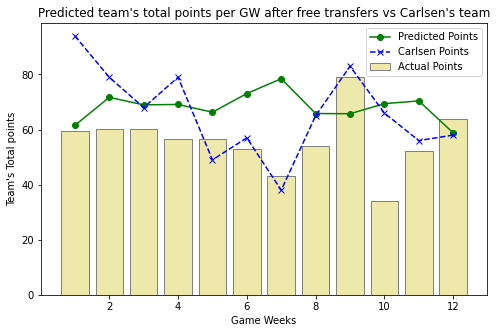

In [ ]:
plt.subplots(figsize=(8,5))

arr_carlsen = [94, 79, 68, 79, 49, 57,38, 65, 83, 66, 56, 58]
plt.title('Predicted team\'s total points per GW after free transfers vs Carlsen\'s team')
plt.xlabel('Game Weeks')
plt.ylabel('Team\'s Total points')
# sns.lineplot(data = gb_final_teams, x= 'GW', y='real_pts_sum')
plt.bar(gb_final_teams['GW'], gb_final_teams['real_pts_sum'],label = "Actual Points", color ='PaleGoldenrod', edgecolor='gray')
plt.plot(gb_final_teams['GW'], gb_final_teams['exp_pts_sum'],'go-', label = "Predicted Points")
plt.plot(gb_final_teams['GW'], arr_carlsen,'bx--', label = "Carlsen Points")
plt.legend()
plt.show()


In [ ]:

gw1_tr_out =gw1_team[gw1_team.name == 'Kelechi Iheanacho']

In [ ]:
gw1_tr_out.name.values[0]

'Kelechi Iheanacho'

In [ ]:
  print("")
  print(f'{Fore.LIGHTBLUE_EX}{Style.BRIGHT}Transfers: GW1')
  display(Markdown("Transfer Out: **Name**= *{}*, **Expected Points** = {},**Real Points** = {}, **Cost** = {}M$, **Position** = {}".format(gw1_tr_out.name.values[0], gw1_tr_out.expected_score.values[0], gw1_tr_out.real_score.values[0], gw1_tr_out.cost.values[0],  gw1_tr_out.position.values[0])))
  display(Markdown("Transfer Out: **Name**= *{}*, **Expected Points** = {},**Real Points** = {}, **Cost** = {}M$, **Position** = {}".format(gw1_tr_out.name.values[0], gw1_tr_out.expected_score.values[0], gw1_tr_out.real_score.values[0], gw1_tr_out.cost.values[0],  gw1_tr_out.position.values[0])))

  # display(Markdown("**Predicted**= *{}*".format(tpoints)))


Transfers: GW1


Transfer Out: **Name**= *Kelechi Iheanacho*, **Expected Points** = 3.2,**Real Points** = 1.0, **Cost** = 7.5M$, **Position** = FWD